# Walmart Analyses Project

### Problem Statment :- A retail store that has multiple outlets across the country are facing issues in managing the inventory - to match the demand with respect to supply.

### * In this notebook i have done analyses on walmart stores's weekly sales and found some importent insist.
### * I have used 3 models ARIMA, SARIMAX, and exponential smoothing for prediction of sales.

### * Importing Libraries

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import warnings
warnings.filterwarnings("ignore")

### * Importing Dataset and checking data for outliers, null values and for duplicate values with doing some basic statistical analyses.

In [2]:
data = pd.read_csv('Walmart.csv',parse_dates=['Date'],index_col='Date')

In [3]:
data.index = pd.to_datetime(data.index,format='%d-%m-%Y')

In [4]:
data[data['Store'] == 1]

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   
...           ...           ...           ...          ...         ...   
2012-09-28      1    1437059.26             0        76.08       3.666   
2012-10-05      1    1670785.97             0        68.55       3.617   
2012-10-12      1    1573072.81             0        62.99       3.601   
2012-10-19      1    1508068.77             0        67.97       3.594   
2012-10-26      1    1493659.74             0        69.16       3.506   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106  
...                ...           ...  
2012-09-28  222.981658         6.908  
2012-10-05  223.181477         6.573  
2012-10-12  223.381296         6.573  
2012-10-19  223.425723         6.573  
2012-10-26  223.444251         6.573  

[143 rows x 7 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [6]:
data.isnull().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7]:
data.duplicated().sum()

0

### -> there are no null or duplicate values.

### * Outlier analyses

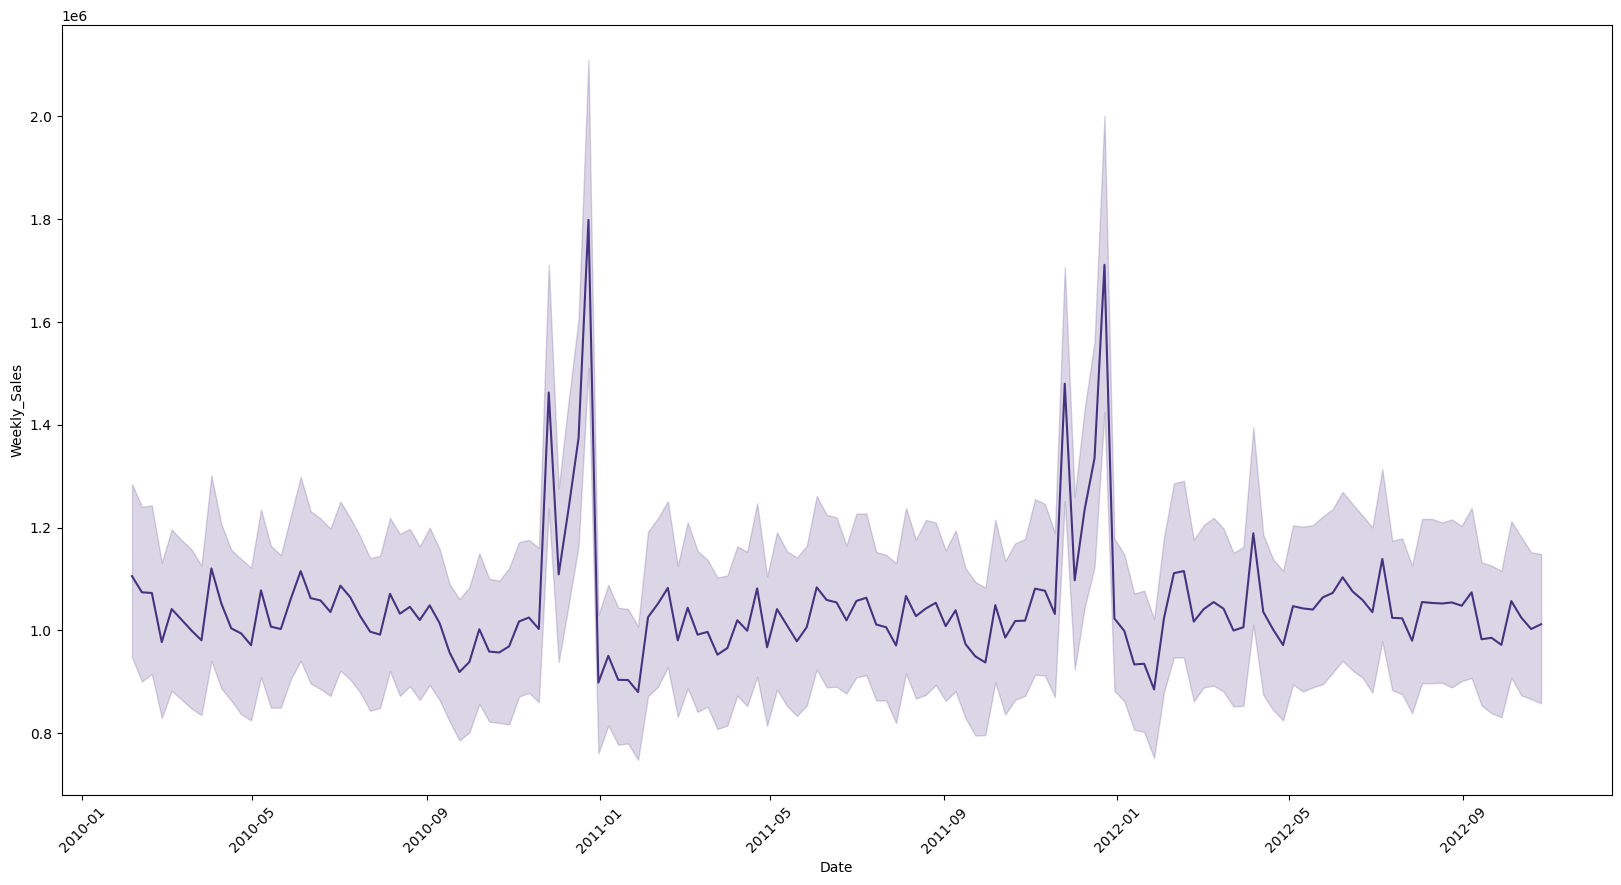

In [90]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=data.index,y=data.Weekly_Sales)
plt.xticks(rotation=45)
plt.show()

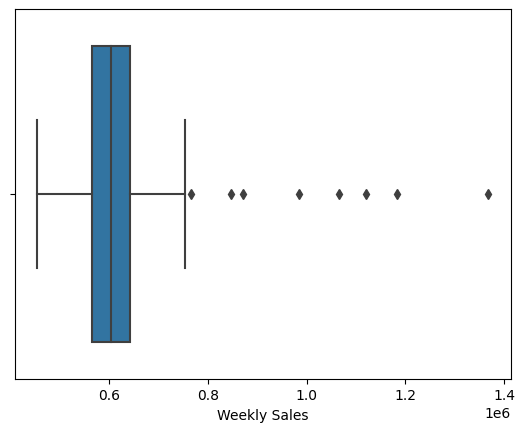

In [9]:
sns.boxplot(x = data[data.Store == 15]['Weekly_Sales'])
plt.xlabel('Weekly Sales')
plt.show()

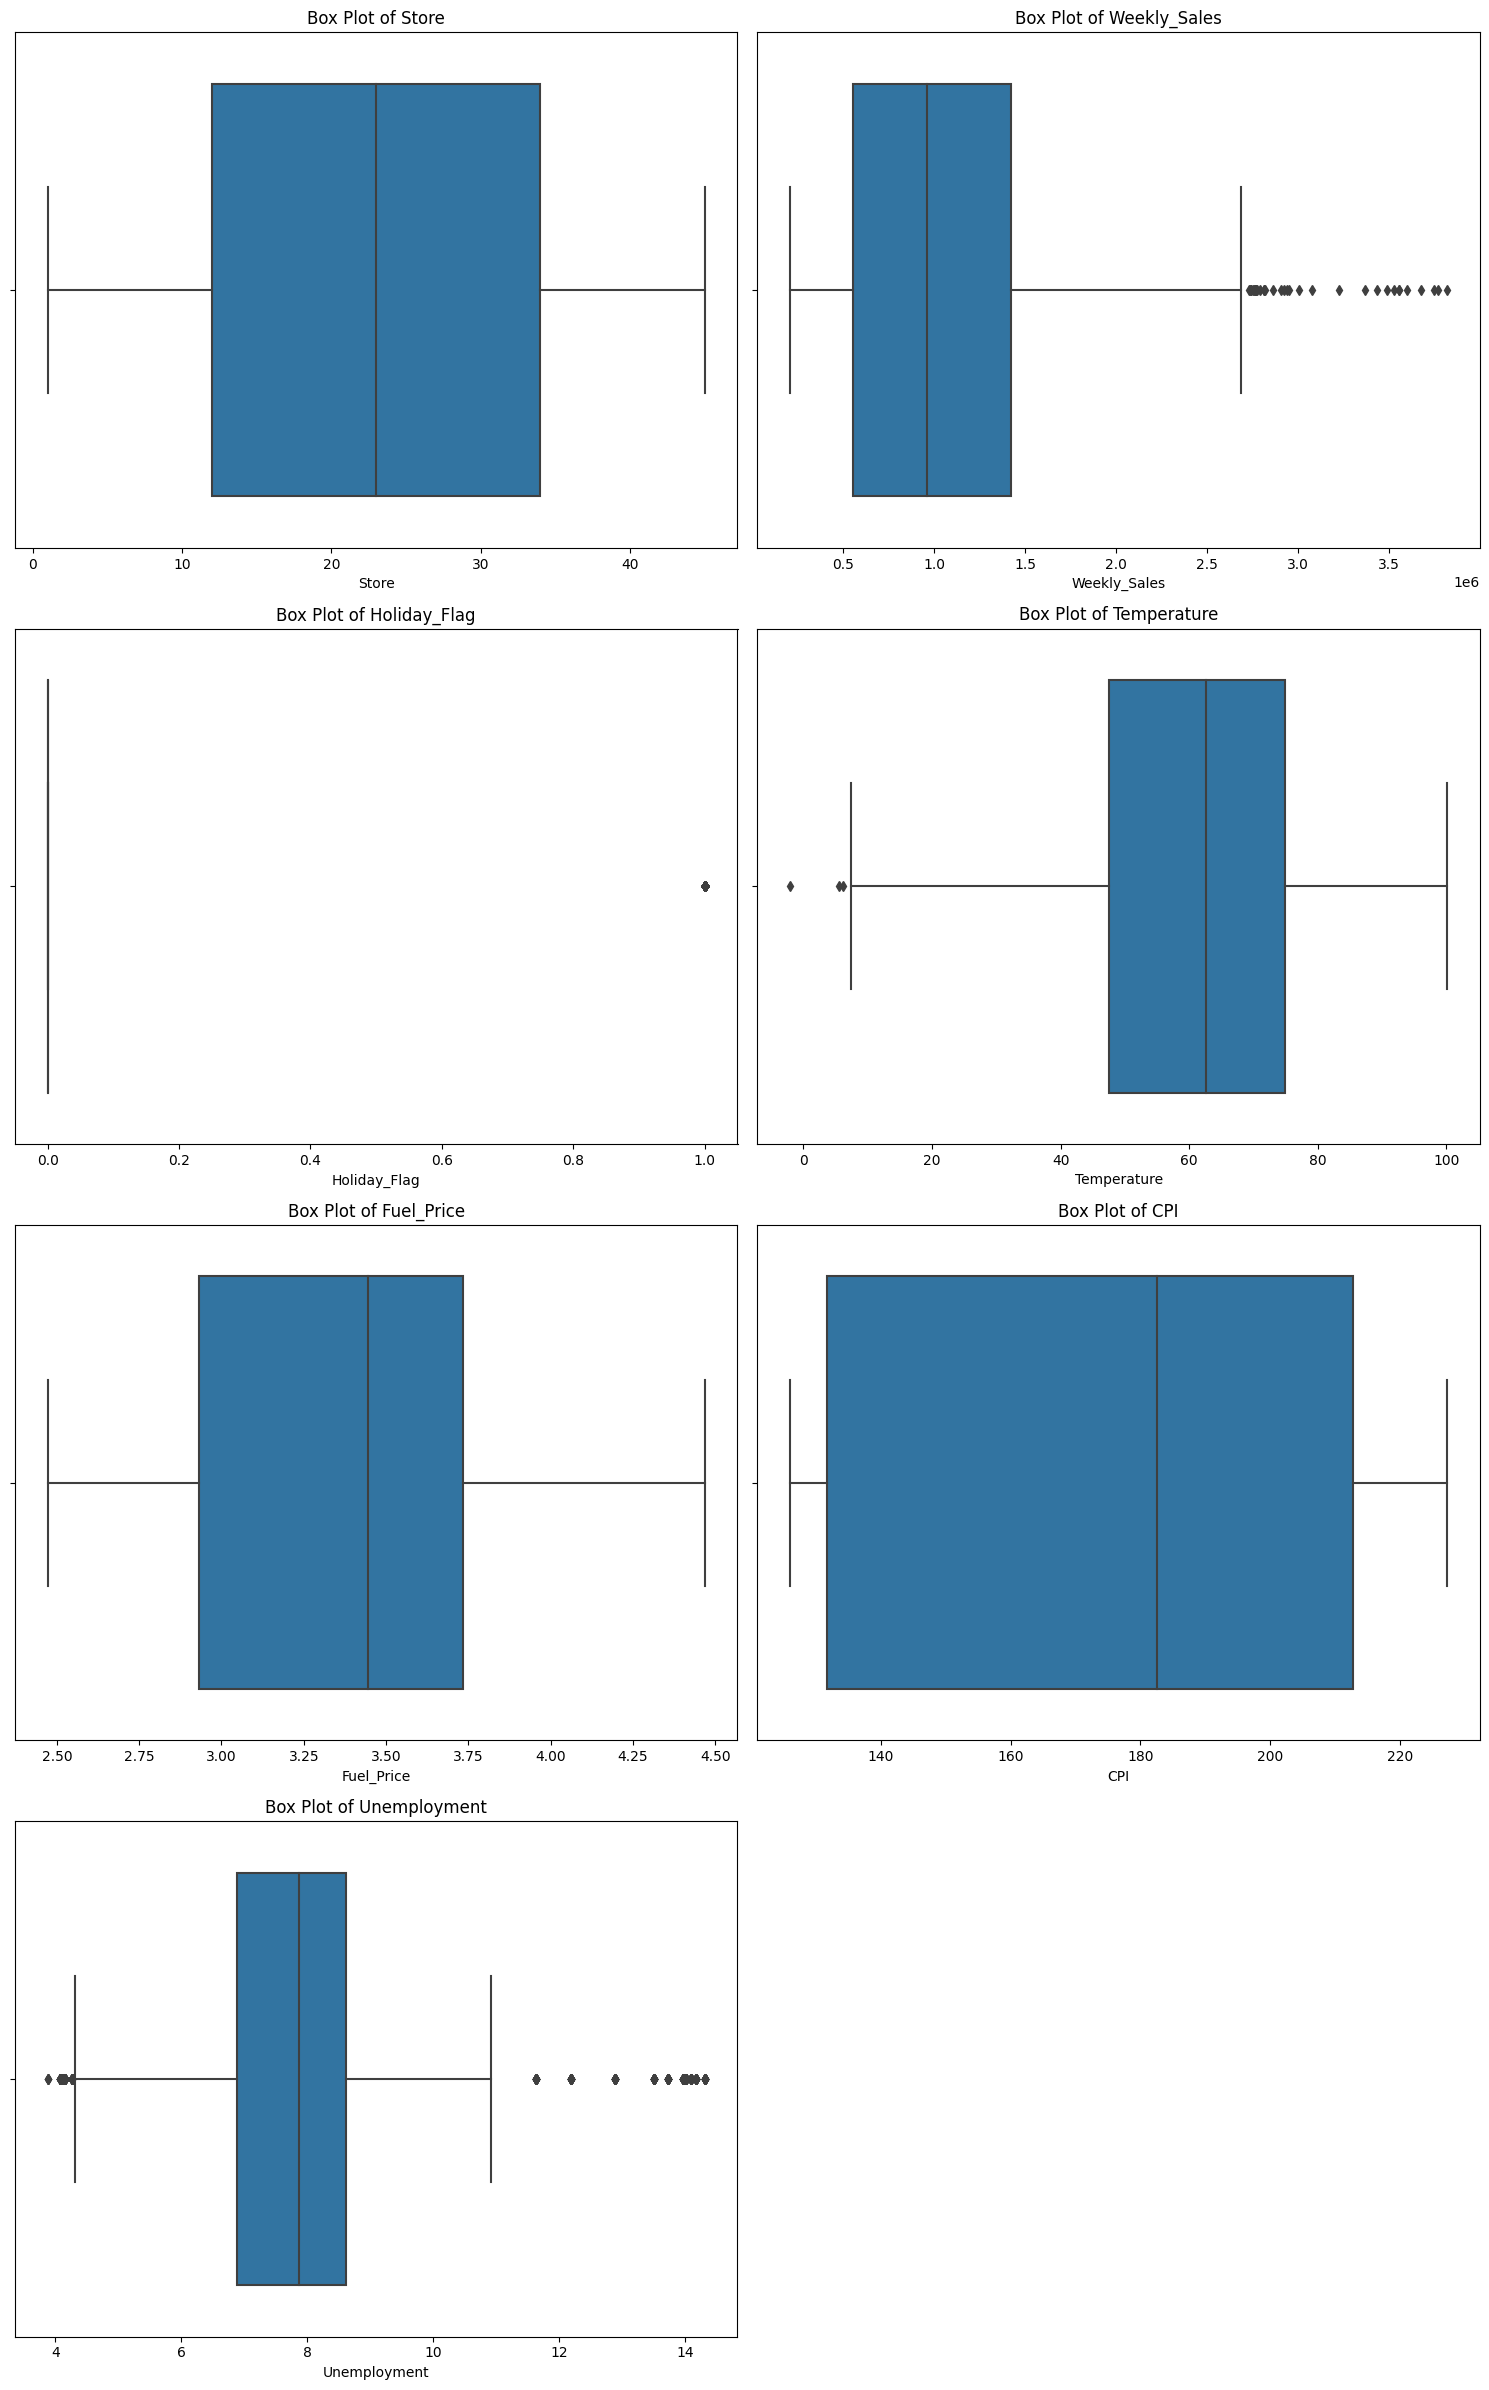

In [10]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

num_cols = 2  
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 6 * num_rows))

for i, column in enumerate(numeric_columns):
    ax = axes[i // num_cols, i % num_cols]
    sns.boxplot(x=data[column], ax=ax)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)

for i in range(len(numeric_columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### * Removing Outliers thd then checking weekly_sales of some stores

In [11]:
columns_to_exclude = ['Store', 'Holiday_Flag', 'Fuel_Price', 'CPI']

def remove_outliers(store_data):
    for column in store_data.columns:
        if column not in columns_to_exclude:
            #print(f'Column: {column} \n')            
            Q1 = store_data[column].quantile(0.25)
            Q3 = store_data[column].quantile(0.75)
            IQR = Q3 - Q1
            
            #print(f'Max : {store_data[column].max()}')
            #print(f'Upper : {Q3 + 1.5 * IQR}')
            #print(f'Lower : {Q1 - 1.5 * IQR} \n')
            
            store_data = store_data[(store_data[column] <= (Q3 + 1.5 * IQR)) & (store_data[column] >= (Q1 - 1.5 * IQR))]
            #print(store_data,'\n')
    return store_data

unique_stores = data['Store'].unique()
df_no_outliers = pd.DataFrame()

for store in unique_stores:
    store_data = data[data['Store'] == store].copy()
    #print('Store No :',store)
    store_data = remove_outliers(store_data)
    df_no_outliers = pd.concat([df_no_outliers, store_data])
    

In [12]:
data.shape

(6435, 7)

In [13]:
df_no_outliers.shape

(6103, 7)

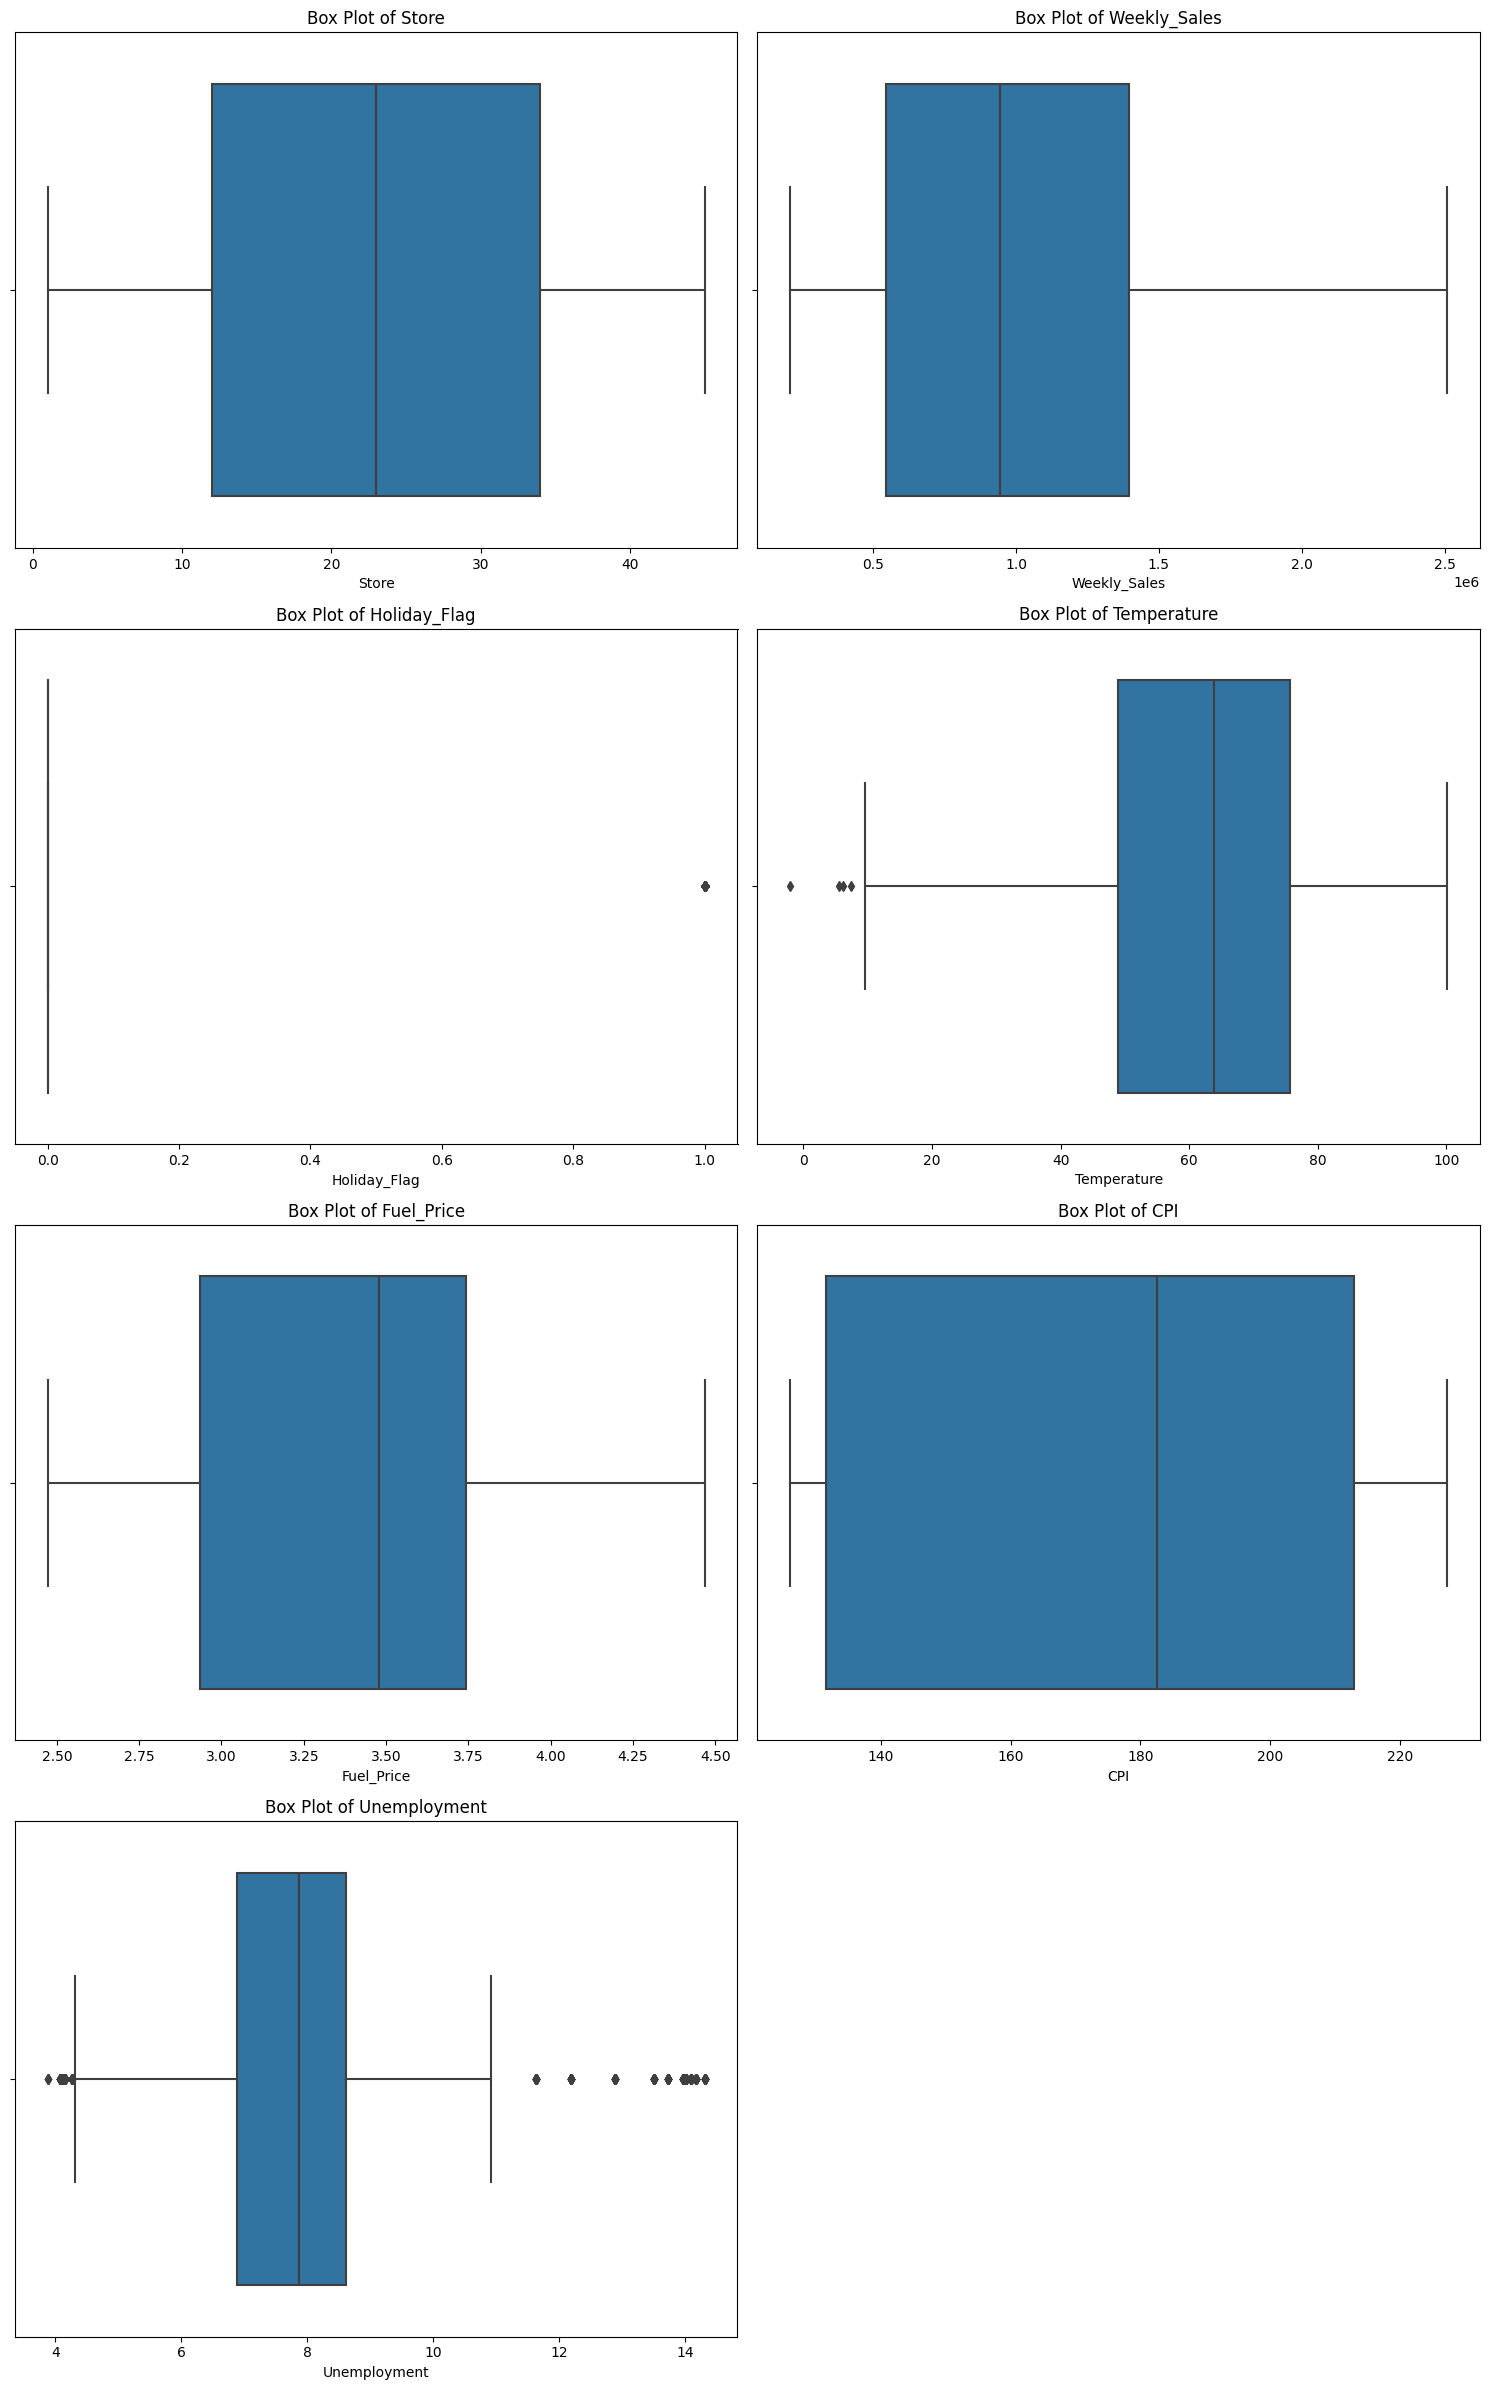

In [14]:
numeric_columns = df_no_outliers.select_dtypes(include=['float64', 'int64']).columns

num_cols = 2  
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 6 * num_rows))

for i, column in enumerate(numeric_columns):
    ax = axes[i // num_cols, i % num_cols]
    sns.boxplot(x=df_no_outliers[column], ax=ax)
    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel(column)

for i in range(len(numeric_columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

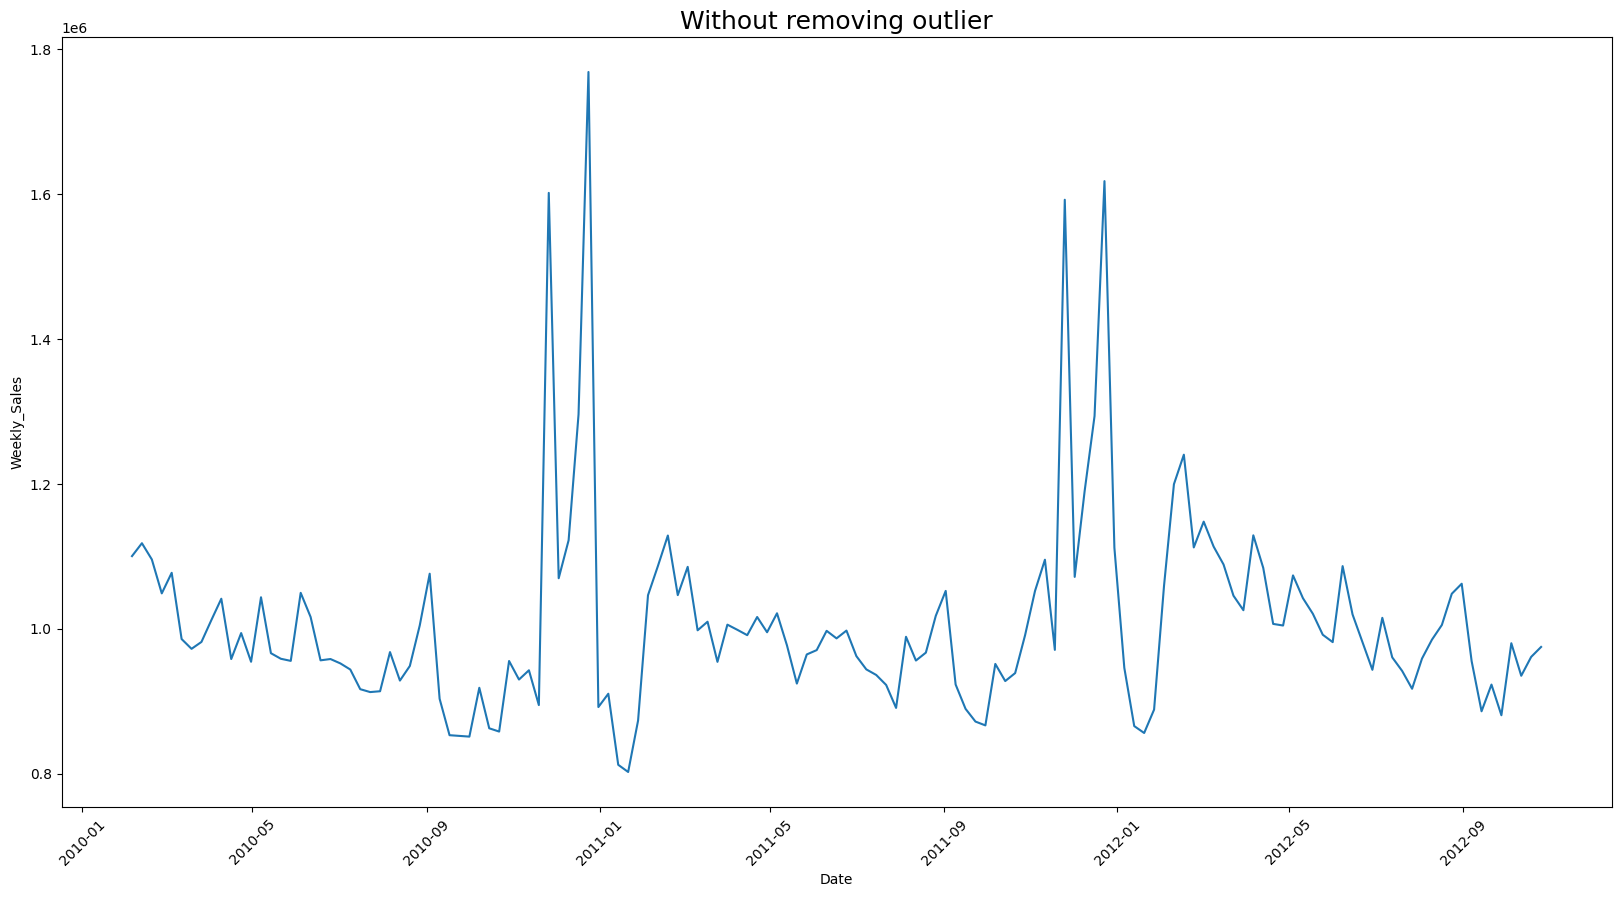

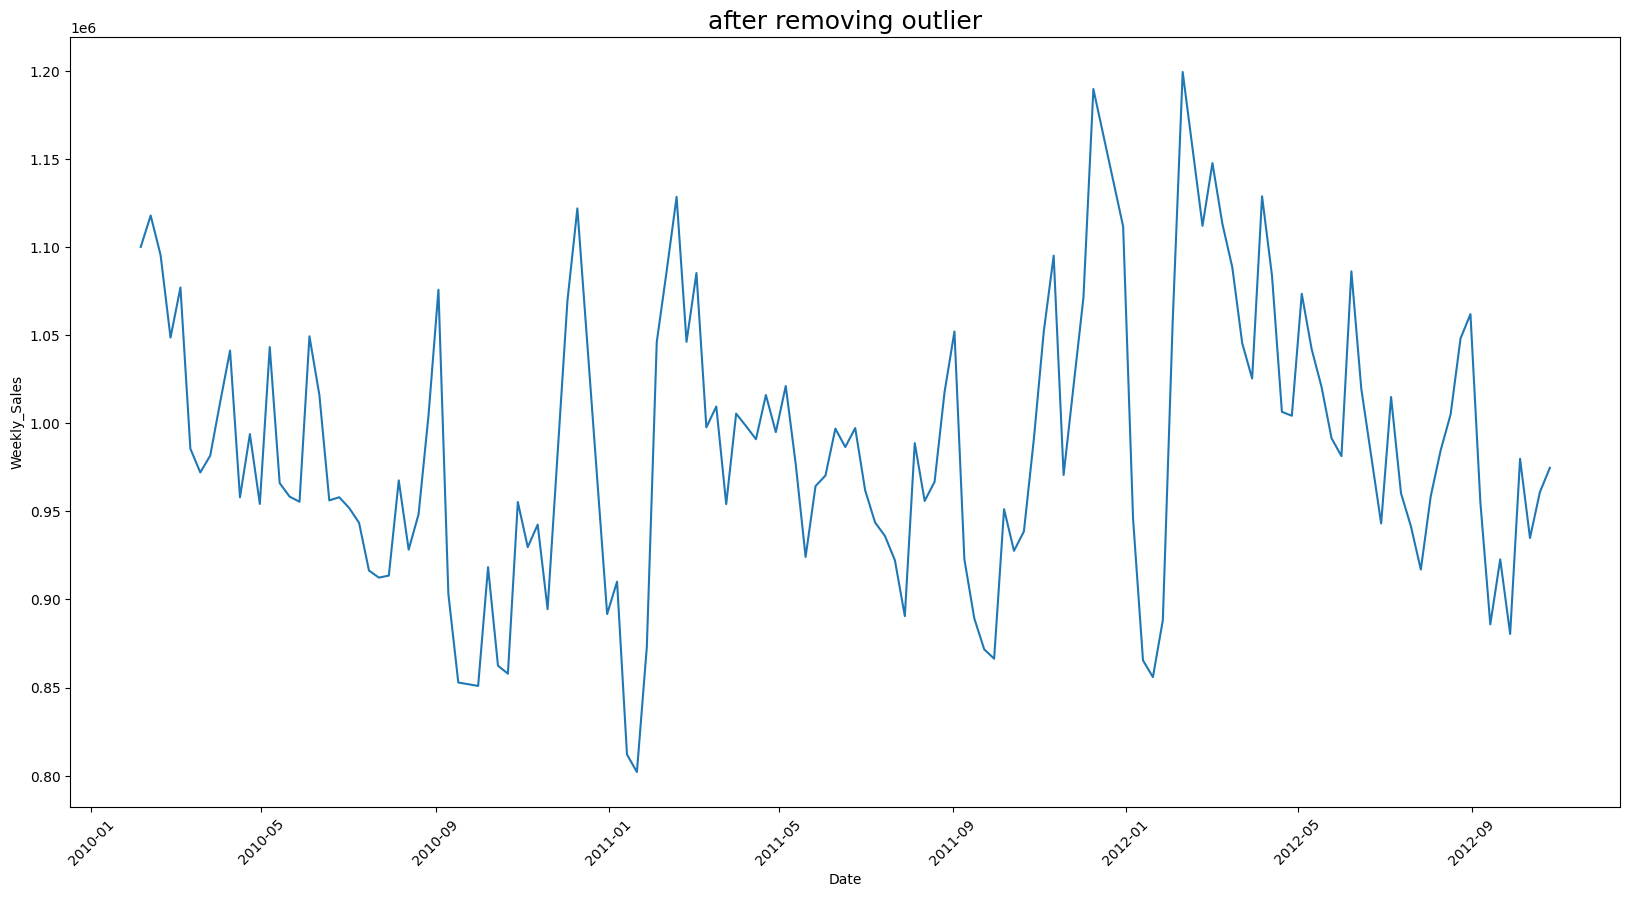

In [15]:
plt.figure(figsize=(20, 10))
sns.lineplot(data[data.Store == 12]['Weekly_Sales'])
plt.title('Without removing outlier', fontsize=18)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 10))
sns.lineplot(df_no_outliers[df_no_outliers.Store == 12]['Weekly_Sales'])
plt.title('after removing outlier', fontsize=18)
plt.xticks(rotation=45)
plt.show()

### -> After Checking Outliers, i think we shoudn't remove outliers.The reason is we can see that there are more outliers in weekly_sales column but this outliers are  helpful for analyses because at every store we have some weekly_sales which is more then value upper bound of box plot which is suggesting that on some weeks the sales was high at every store at every year which suggest seasonality, May be the reason behind this is holydays or festivals.

### -> We can also see plots before removing outliers and after removing outliers, if we remove outliers then we loos out seasonality so our model won't work better in prediction of seasonality.

### *  Now let's Perform analyses on every column so that we can get insists

In [16]:
data.corr(numeric_only=True)

Store  Weekly_Sales  Holiday_Flag  Temperature  \
Store         1.000000e+00     -0.335332 -4.386841e-16    -0.022659   
Weekly_Sales -3.353320e-01      1.000000  3.689097e-02    -0.063810   
Holiday_Flag -4.386841e-16      0.036891  1.000000e+00    -0.155091   
Temperature  -2.265908e-02     -0.063810 -1.550913e-01     1.000000   
Fuel_Price    6.002295e-02      0.009464 -7.834652e-02     0.144982   
CPI          -2.094919e-01     -0.072634 -2.162091e-03     0.176888   
Unemployment  2.235313e-01     -0.106176  1.096028e-02     0.101158   

              Fuel_Price       CPI  Unemployment  
Store           0.060023 -0.209492      0.223531  
Weekly_Sales    0.009464 -0.072634     -0.106176  
Holiday_Flag   -0.078347 -0.002162      0.010960  
Temperature     0.144982  0.176888      0.101158  
Fuel_Price      1.000000 -0.170642     -0.034684  
CPI            -0.170642  1.000000     -0.302020  
Unemployment   -0.034684 -0.302020      1.000000

In [17]:
data.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

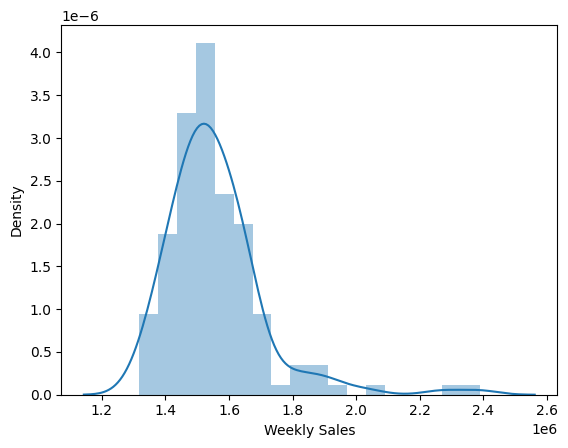

In [18]:
sns.distplot(data[data.Store == 1]['Weekly_Sales'])
plt.xlabel('Weekly Sales')
plt.ylabel('Density')  # Assuming you are plotting a density plot

# Show the plot
plt.show()

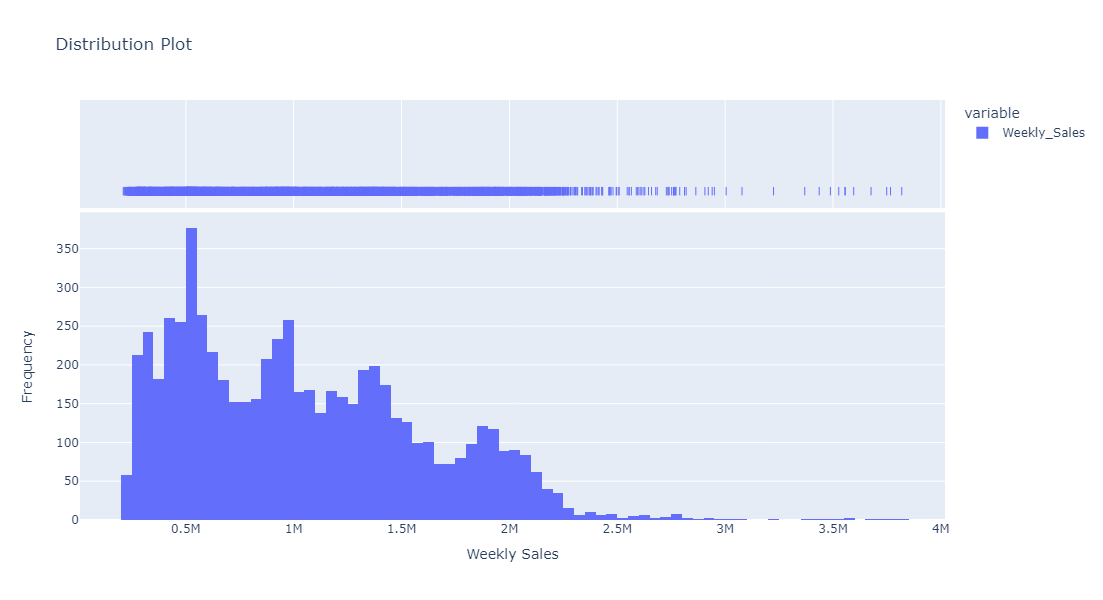

In [93]:
fig = px.histogram(data.Weekly_Sales, marginal="rug", title='Distribution Plot', labels={'value': 'Weekly_Sales'})

fig.update_layout(
    xaxis_title='Weekly Sales',
    yaxis_title='Frequency',
    width=1100,
    height=600,
)
fig.show()

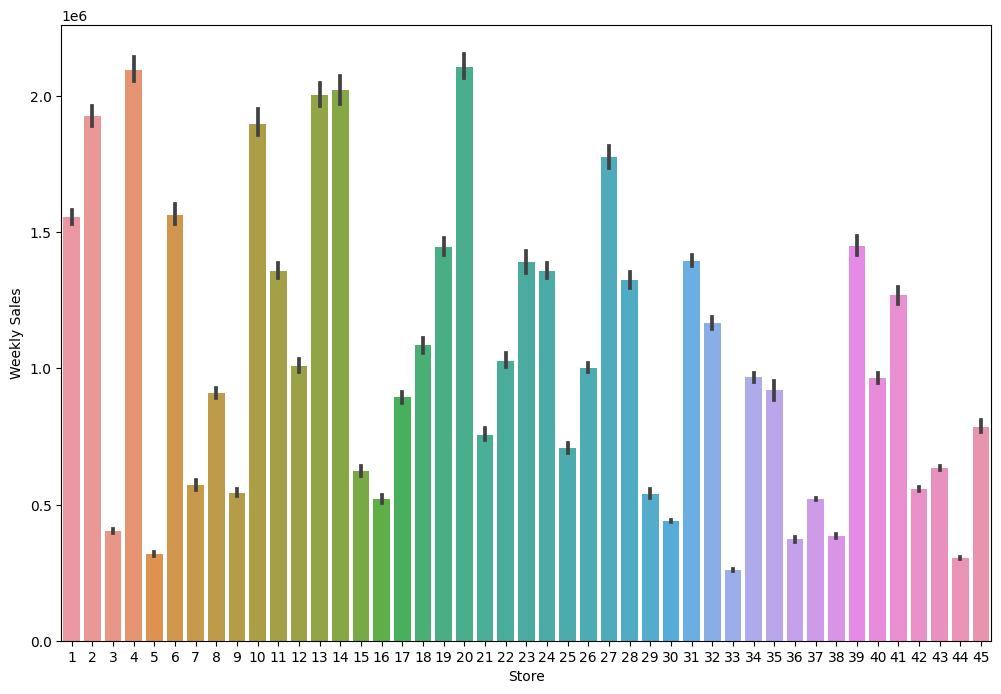

In [75]:
plt.figure(figsize=(12, 8))
sns.barplot(x=data.Store,y=data.Weekly_Sales) 

plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.show()

In [21]:
holidays = data.groupby('Store')['Holiday_Flag'].sum()

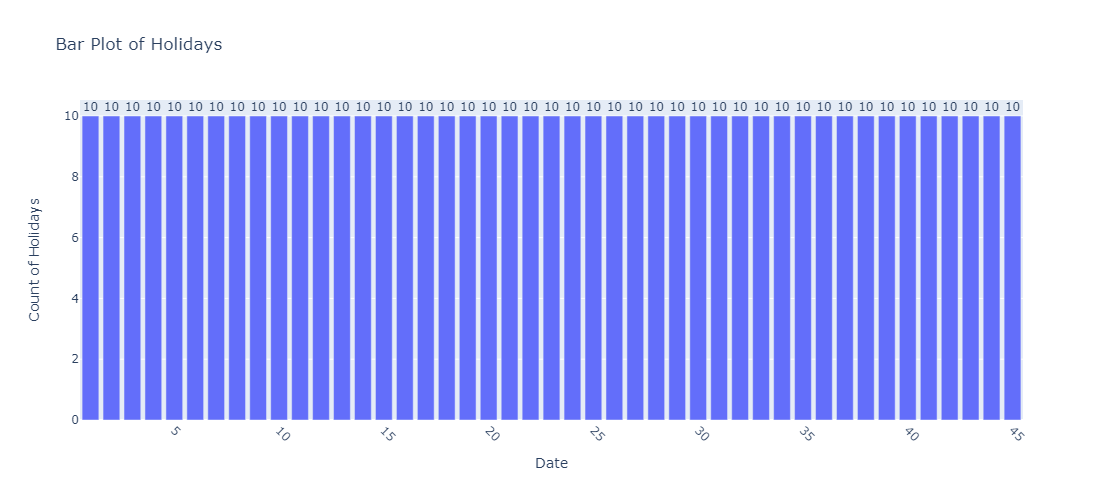

In [91]:
fig = px.bar(x=holidays.index, y=holidays.values, title='Bar Plot of Holidays',
             labels={'y': 'Count'}, text=holidays.values)

fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    xaxis_title='Date',
    yaxis_title='Count of Holidays',
    xaxis=dict(tickangle=45),
)

fig.show()

### -> We can see all stores has equal number of Holiday_Flag.

## * Now we will answer some question related to business.

### Q1) :- If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

In [23]:
data

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   
...           ...           ...           ...          ...         ...   
2012-09-28     45     713173.95             0        64.88       3.997   
2012-10-05     45     733455.07             0        64.89       3.985   
2012-10-12     45     734464.36             0        54.47       4.000   
2012-10-19     45     718125.53             0        56.47       3.969   
2012-10-26     45     760281.43             0        58.85       3.882   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106  
...                ...           ...  
2012-09-28  192.013558         8.684  
2012-10-05  192.170412         8.667  
2012-10-12  192.327265         8.667  
2012-10-19  192.330854         8.667  
2012-10-26  192.308899         8.667  

[6435 rows x 7 columns]

In [24]:
data.corr()['Unemployment']

Store           0.223531
Weekly_Sales   -0.106176
Holiday_Flag    0.010960
Temperature     0.101158
Fuel_Price     -0.034684
CPI            -0.302020
Unemployment    1.000000
Name: Unemployment, dtype: float64

### -> We can see that there is weak negative correlation between Weekly_Sales and Unemployment. Let's check for every store.    

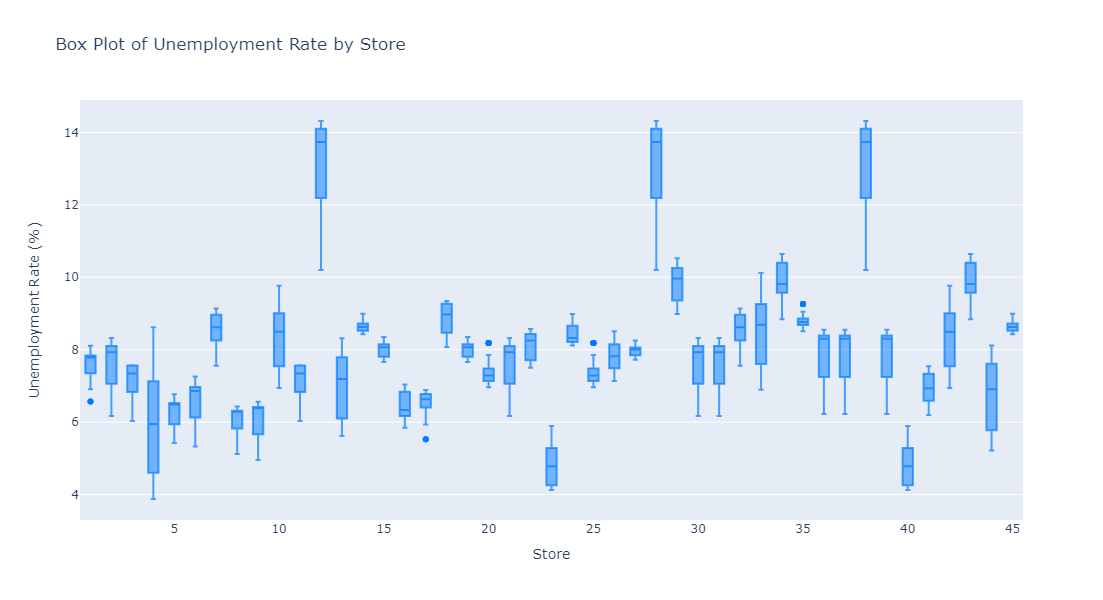

In [77]:
fig = px.box(x = data.Store,y = data.Unemployment,title='Box Plot of Unemployment Rate by Store',
             labels={'Store': 'Store', 'Unemployment': 'Unemployment Rate (%)'})

fig.update_traces(marker_color='rgba(0, 123, 255, 0.7)')

fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
    xaxis_title='Store',
    yaxis_title='Unemployment Rate (%)',
)

fig.show()

In [78]:
correlation_data_list = []

for store in data['Store'].unique():
    store_data = data[data['Store'] == store]
    
    correlation_value = store_data['Weekly_Sales'].corr(store_data['Unemployment'])
    
    correlation_data_list.append({'Store': store, 'Correlation': correlation_value})
    
correlation_data = pd.DataFrame(correlation_data_list)

# another simple way

# correlation_Unemployment_sales_by_store = data.groupby('Store')[['Unemployment', 'Weekly_Sales']].corr().iloc[0::2, -1].reset_index()
# correlation_Unemployment_sales_by_store.drop(columns = 'level_1')

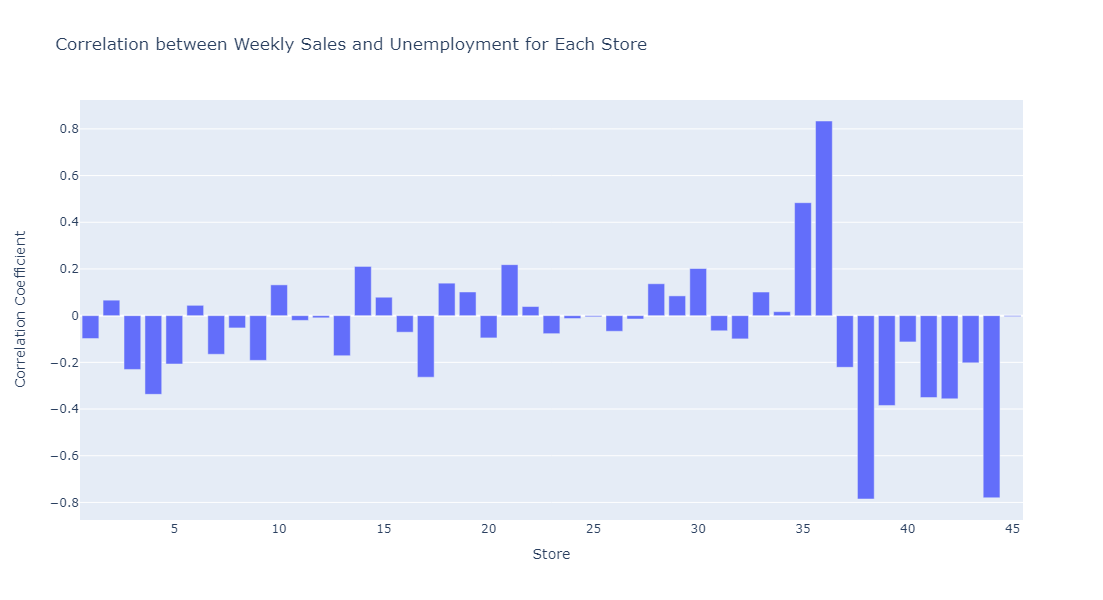

In [81]:
fig = px.bar(x=correlation_data.Store, y=correlation_data.Correlation,
             title='Correlation between Weekly Sales and Unemployment for Each Store',
             labels={'Store': 'Store', 'Correlation': 'Correlation Coefficient'})

fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
    xaxis_title='Store',
    yaxis_title='Correlation Coefficient',
)

fig.show()

### Ans 1 :-  
### -> Here, we can see that the overall correlation between unemployment and weekly sales is -0.106176, which is very weak. However, some stores like store No. 38 and 44 are strongly negatively correlated with the unemployment column, while some stores like store No. 2, 4, 18, 39, 41,42 and 43 are weakly negatively correlated with the unemployment column. It's not a strong correlation, but at some level, they are related.

### -> Other Stores like 35,36 are strongly highly positively and 14,21,30 are weakly positively correlated with unemployment column.

### -> So we can say unemploymnt feature is affecting weekly sales of only some stores, when unemployment rate is incresing the weekly sales of some stores are descresing and vise-versa.

### -> Some stores's sales are affected by unemployment beacuse thay can be located at some place where population is less.

### Q2) :- If the weekly sales show a seasonal trend, when and what could be the reason?

In [82]:
data

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   
...           ...           ...           ...          ...         ...   
2012-09-28     45     713173.95             0        64.88       3.997   
2012-10-05     45     733455.07             0        64.89       3.985   
2012-10-12     45     734464.36             0        54.47       4.000   
2012-10-19     45     718125.53             0        56.47       3.969   
2012-10-26     45     760281.43             0        58.85       3.882   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106  
...                ...           ...  
2012-09-28  192.013558         8.684  
2012-10-05  192.170412         8.667  
2012-10-12  192.327265         8.667  
2012-10-19  192.330854         8.667  
2012-10-26  192.308899         8.667  

[6435 rows x 7 columns]

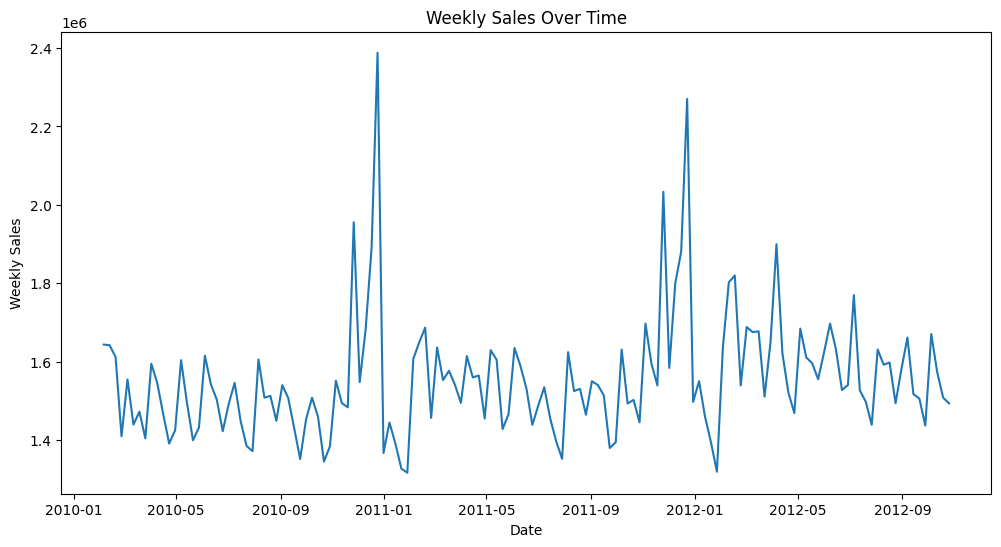

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(data[data['Store'] == 1]['Weekly_Sales'])
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

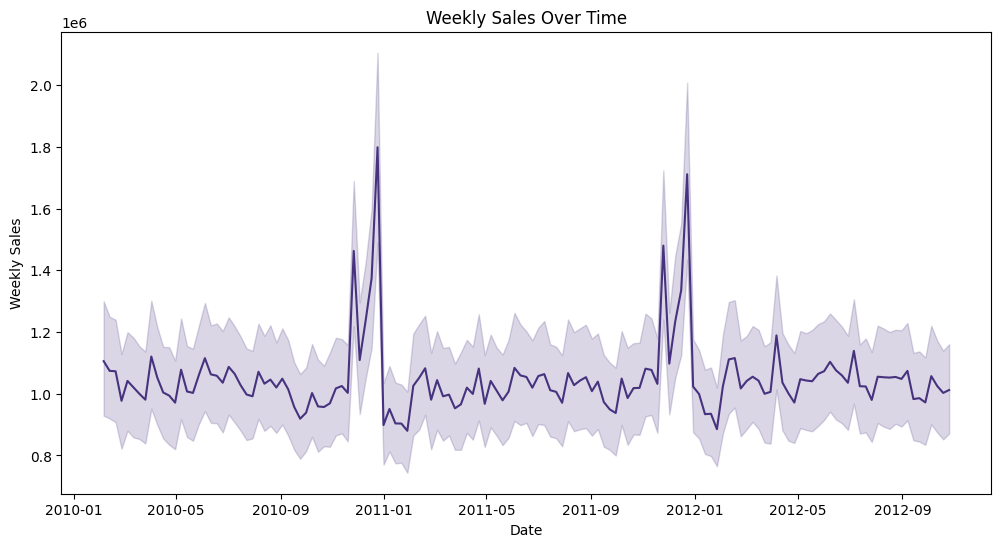

In [96]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index,y=data.Weekly_Sales)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

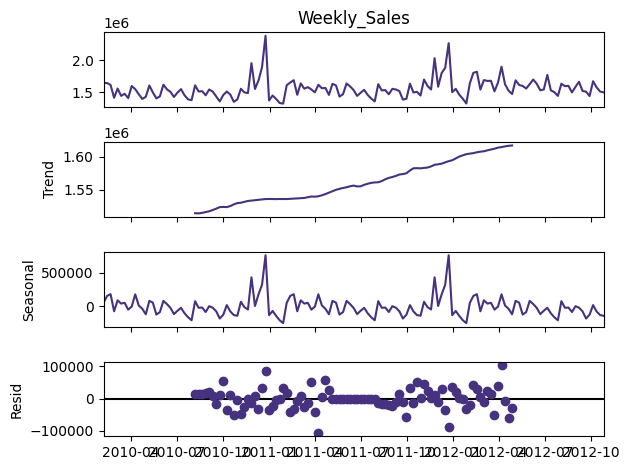

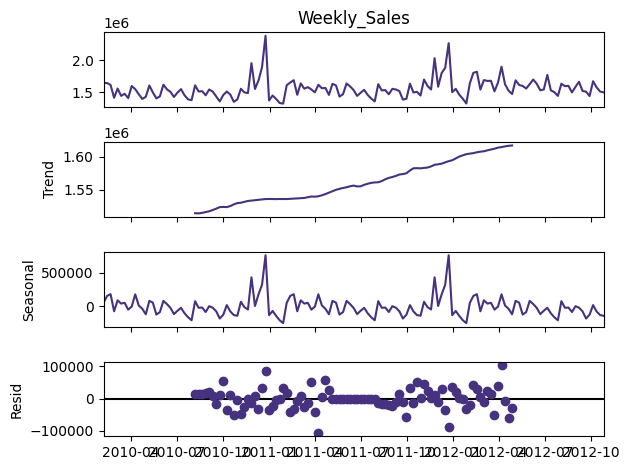

In [97]:
decomposition = seasonal_decompose(data[data['Store'] == 1]['Weekly_Sales'], period=52)
decomposition.plot()

In [94]:
Sales_mean = data.groupby('Date')['Weekly_Sales'].mean()

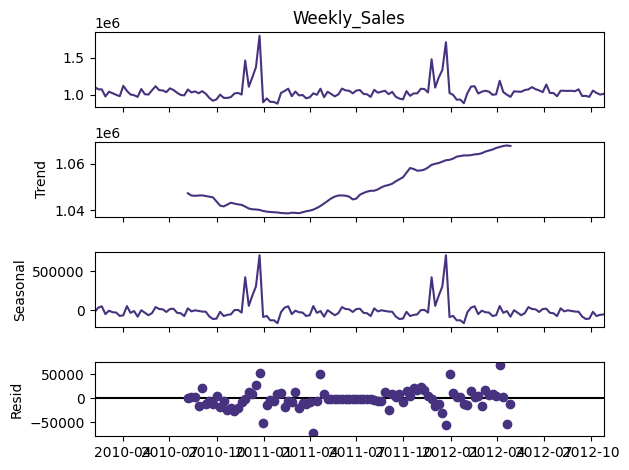

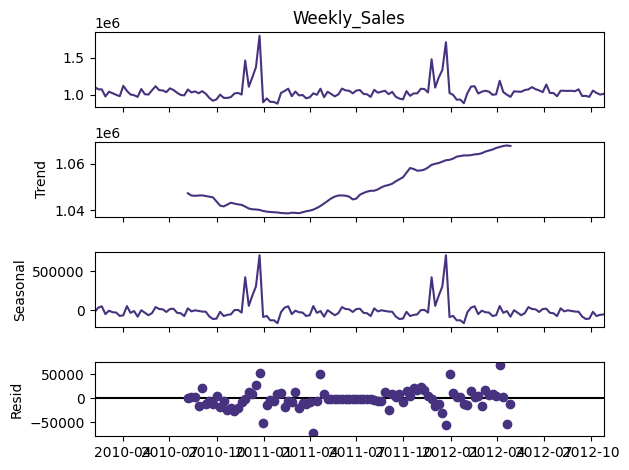

In [95]:
decomposition = seasonal_decompose(Sales_mean,period=52)
decomposition.plot()

### Ans 2 :- Yes, weekly sales show a seasonal trend in most of shops between November to January.

### Reasons:

### -> 1) The reason behind that is the period from late November to early January encompasses major holidays such as Thanksgiving, Christmas, and New Year's. During this time, consumers tend to increase their spending on gifts, decorations, and festive items.

### -> 2) Many retailers offer special promotions, discounts, and sales events during the holiday season to attract shoppers. This can lead to an increase in consumer spending.

### -> 3) The tradition of gift-giving during holidays contributes significantly to increased sales, especially for items considered as gifts.

### Q3) :- Does temperature affect the weekly sales in any manner?

In [39]:
data.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106

In [40]:
data.corr()['Temperature']

Store          -0.022659
Weekly_Sales   -0.063810
Holiday_Flag   -0.155091
Temperature     1.000000
Fuel_Price      0.144982
CPI             0.176888
Unemployment    0.101158
Name: Temperature, dtype: float64

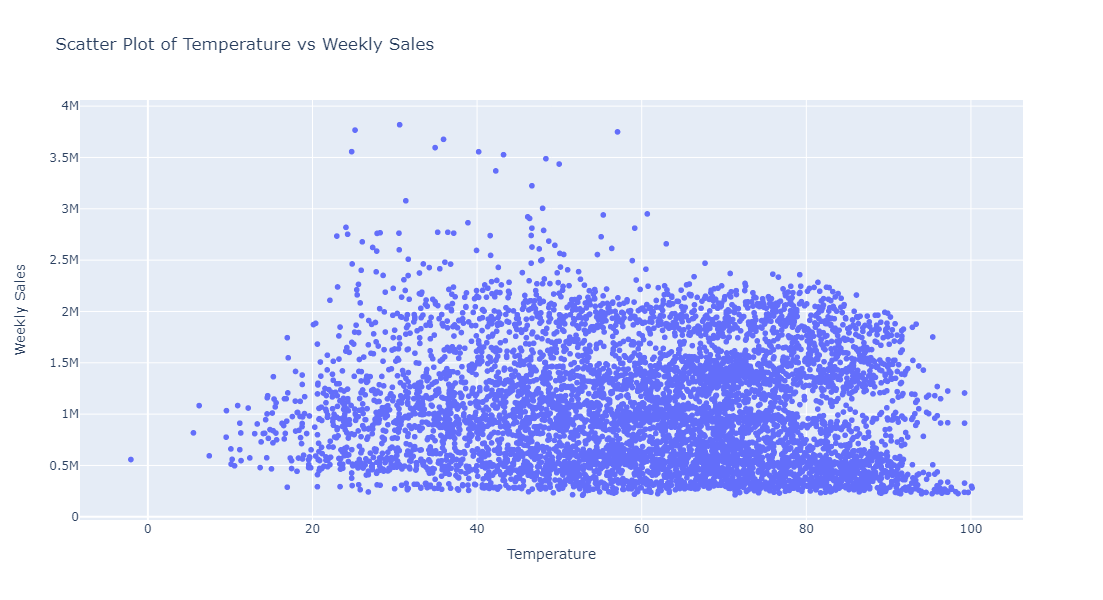

In [98]:
fig = px.scatter(data, x='Temperature', y='Weekly_Sales', title='Scatter Plot of Temperature vs Weekly Sales',
                 labels={'Temperature': 'Temperature', 'Weekly_Sales': 'Weekly Sales'})

fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
)

fig.show()

### Ans 3:-

### -> In this case, the correlation coefficient is close to 0, suggesting a weak or no linear relationship between weekly sales and temperature. 
### -> The negative sign indicates a slight negative correlation,  but the strength of the correlation is considered weak. Therefore, based on this correlation coefficient,there is not a strong linear relationship between weekly sales and temperature in your dataset.

### Q4) :- How is the Consumer Price index affecting the weekly sales of various stores?

In [99]:
data['CPI'].corr(data['Weekly_Sales'])

-0.0726341620401763

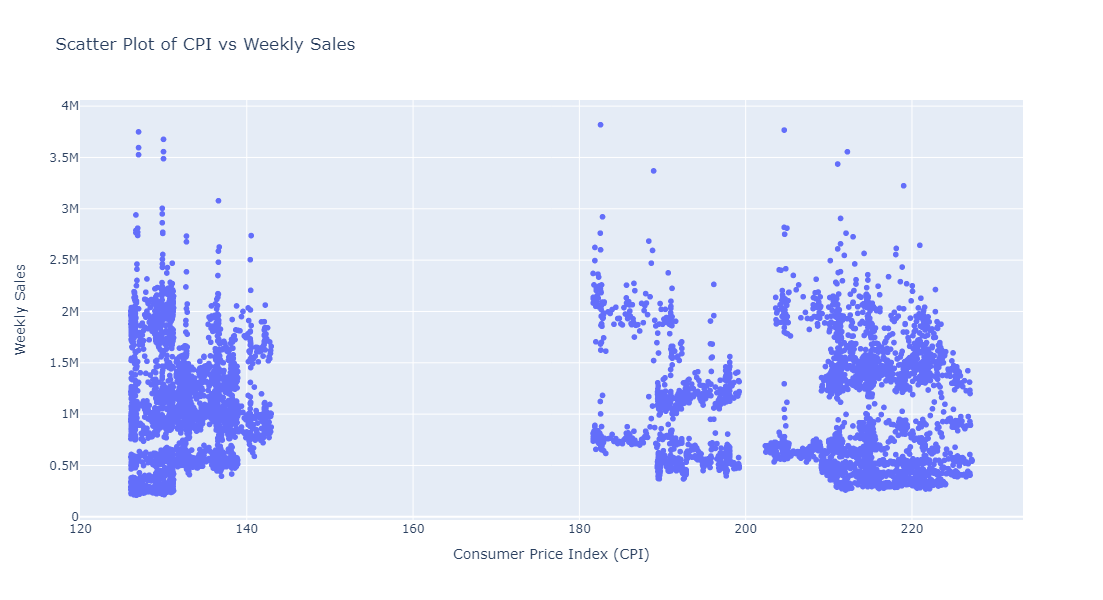

In [101]:
fig = px.scatter(x=data.CPI, y=data.Weekly_Sales, title='Scatter Plot of CPI vs Weekly Sales',
                 labels={'CPI': 'Consumer Price Index (CPI)', 'Weekly_Sales': 'Weekly Sales'})

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    xaxis_title='Consumer Price Index (CPI)',
    yaxis_title='Weekly Sales',
)

fig.show()

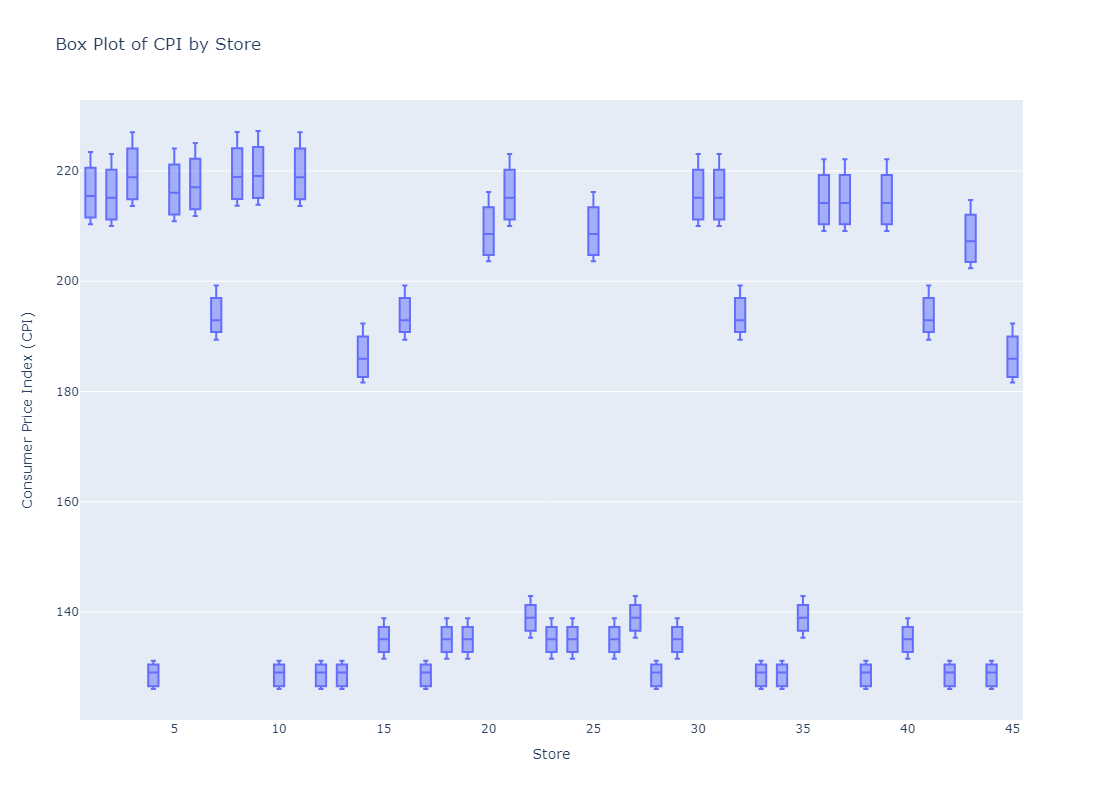

In [102]:
fig = px.box(x=data.Store, y=data.CPI, title='Box Plot of CPI by Store',
             labels={'Store': 'Store', 'CPI': 'Consumer Price Index (CPI)'})

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title='Store',
    yaxis_title='Consumer Price Index (CPI)',
)

fig.show()

In [103]:
correlation_cpi_sales_by_store = data.groupby('Store')[['CPI', 'Weekly_Sales']].corr().iloc[0::2, -1].reset_index()
correlation_cpi_sales_by_store.drop(columns = 'level_1',inplace=True)

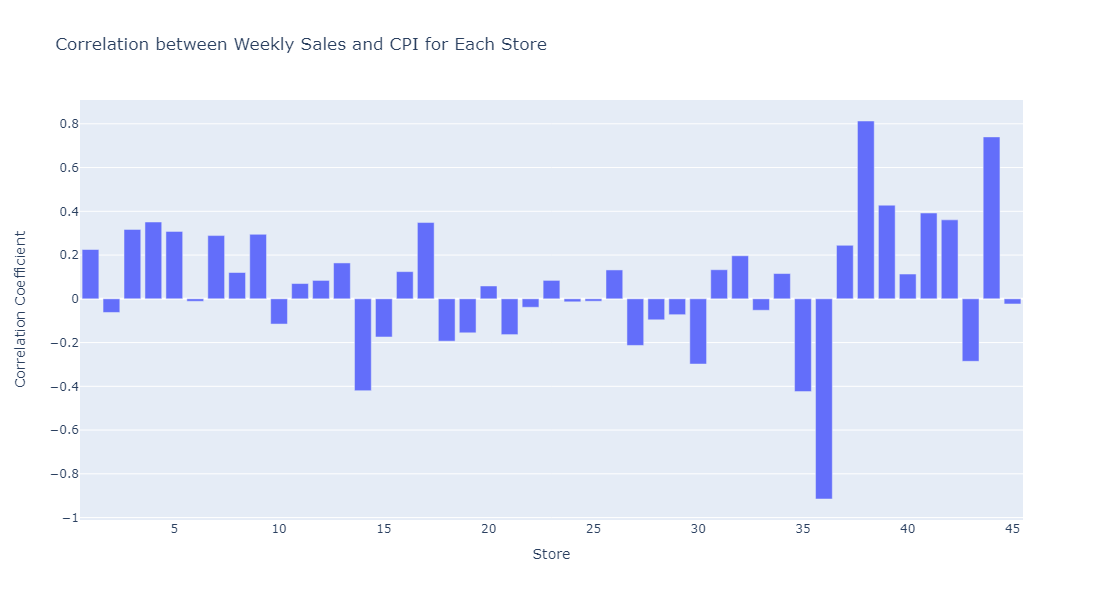

In [115]:
fig = px.bar(x=correlation_cpi_sales_by_store.Store, y=correlation_cpi_sales_by_store.Weekly_Sales,
             title='Correlation between Weekly Sales and CPI for Each Store',
             labels={'Store': 'Store', 'Weekly_Sales': 'Correlation Coefficient'})

fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
    xaxis_title='Store',
    yaxis_title='Correlation Coefficient',
)

fig.show()

### Ans 4 :- 
### -> The overall correlation coefficient between the Consumer Price Index (CPI) and Weekly Sales is approximately -0.0726. 

### -> The negative correlation suggests a weak inverse relationship between the Consumer Price Index and Weekly Sales. However, the correlation is relatively low, indicating that there isn't a strong linear relationship between these two variables.

### -> A negative correlation implies that as the Consumer Price Index decreases (or remains low), the Weekly Sales may slightly increase, and vice versa.
### ->The low magnitude of the correlation suggests that other factors beyond CPI are likely influencing Weekly Sales more significantly.

### -> However There are some store that are affected by CPI like store no. 14,36,35,43 has strong negative correlation Where as some stores like store no 38,39,41,42,44 has  strong negative correlation that we can see in graph.

### Q5) :- Top performing stores according to the historical data.

In [116]:
Sales_Stores = data.groupby('Store')['Weekly_Sales'].sum()

In [117]:
Top_Stores = Sales_Stores.sort_values(ascending=False).head(5)
Top_Stores_formatted = Top_Stores.apply(lambda x: format(x, ','))
print(Top_Stores_formatted)

Store
20    301,397,792.46
4     299,543,953.38
14    288,999,911.34
13     286,517,703.8
2     275,382,440.98
Name: Weekly_Sales, dtype: object


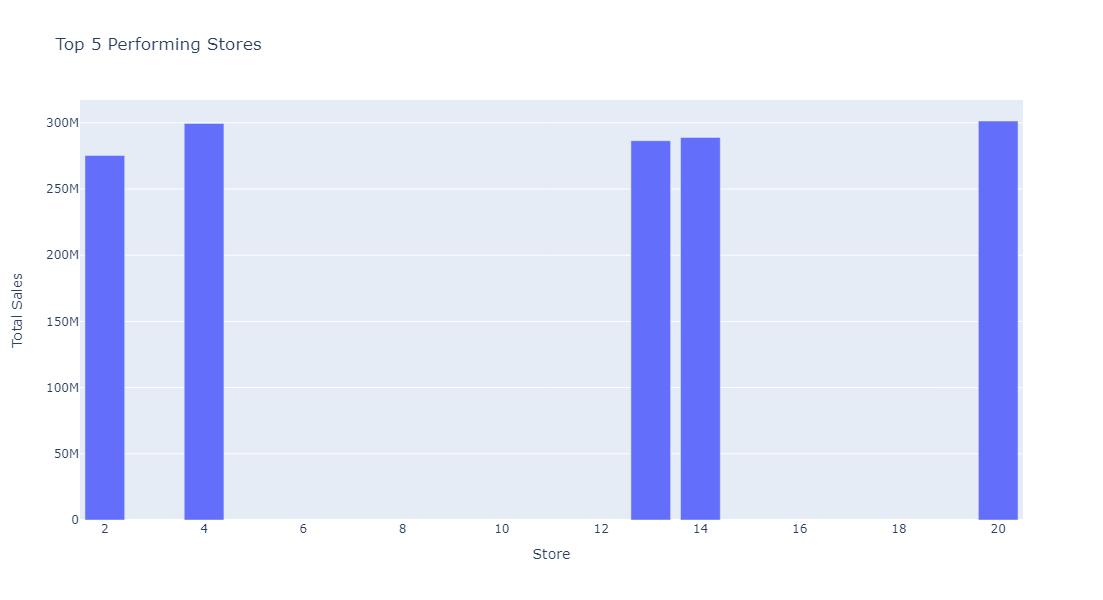

In [121]:
fig = px.bar(Top_Stores, x=Top_Stores.index.values, y=Top_Stores.values, title='Top 5 Performing Stores')
fig.update_layout(xaxis_title='Store', yaxis_title='Total Sales',width=1100,height=600,)
fig.show()

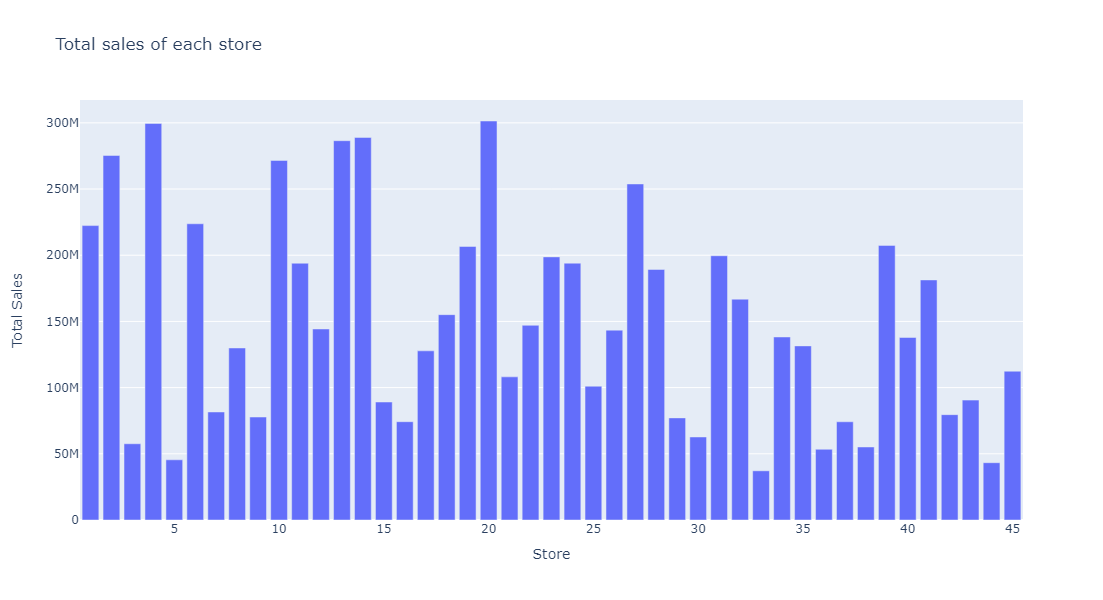

In [122]:
fig = px.bar(Sales_Stores, x=Sales_Stores.index, y=Sales_Stores.values, title='Total sales of each store')
fig.update_layout(xaxis_title='Store', yaxis_title='Total Sales',width=1100,height=600,)
fig.show()

### Ans 5 :- 
### -> From the above Graph we can see top selling stores are store no 2,4,13,14,20 according to sales that thay have made.

### Q6) :- The worst performing store, and how significant is the difference between the highest and lowest performing stores.

In [123]:
Top_performer_store = Top_Stores.head(1)
Top_performer_store

Store
20    3.013978e+08
Name: Weekly_Sales, dtype: float64

In [48]:
Worst_performer_store = Sales_Stores.sort_values(ascending=True).head(1)
Worst_performer_store

Store
33    37160221.96
Name: Weekly_Sales, dtype: float64

In [49]:
difference = Top_performer_store.values[0] - Worst_performer_store.values[0]

worst_store_index = Worst_performer_store.index.values[0]
worst_store_sales = Worst_performer_store.values[0]

best_store_index = Top_performer_store.index.values[0]
best_store_sales = Top_performer_store.values[0]

print(f"The worst-performing store is Store No. {worst_store_index} with total sales of {worst_store_sales:.2f}")
print(f"The best-performing store is Store No. {best_store_index} with total sales of {best_store_sales:.2f}")
print(f"The difference in total sales between the highest and lowest performing stores is {difference:.2f}")


The worst-performing store is Store No. 33 with total sales of 37160221.96
The best-performing store is Store No. 20 with total sales of 301397792.46
The difference in total sales between the highest and lowest performing stores is 264237570.50


### Ans 6 :- 
### -> The worst-performing store is Store No. 33 with total sales of 37160221.96.
### -> The best-performing store is Store No. 20 with total sales of 301397792.46.
### -> The difference in total sales between the highest and lowest performing stores is 264237570.50.

## Model Building

### * Now we will do prdiction of weekly_sales using time series models for 4 stores and at last we will predict overall sum of week sales by all stores for next 12 weeks.

## Functions

In [189]:
def load_store_data(data, store_number='All'):
    if store_number == 'All':
        store_data = data.groupby('Date')['Weekly_Sales'].sum()
        store_data = pd.DataFrame({'Weekly_Sales': store_data})
    else:
        store_data = data[data['Store'] == store_number].drop(columns=['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
    return store_data


def visualize_sales(data):
    fig = px.line(data, x=data.index, y='Weekly_Sales', title='Sales',
                  labels={'Weekly_Sales': 'Weekly Sales'})

    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        xaxis_title='Date',
        yaxis_title='Weekly Sales',
        xaxis=dict(tickangle=45),
    )

    fig.show()

def plot_rolling_statistics(data, window=12):
    plt.figure(figsize=(12, 6))
    mean_log = data.rolling(window=window).mean()
    std_log = data.rolling(window=window).std()

    plt.plot(data, color='blue', label='Original')
    plt.plot(mean_log, color='red', label='Rolling Mean')
    plt.plot(std_log, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.title('Rolling Mean and Rolling Std')
    plt.show()

def apply_log_transformation(data):
    first_log = np.log(data)
    first_log = first_log.dropna()
    return first_log

def apply_diff_transformation(data):
    first_shift = data.shift()
    first_diff = data - first_shift 
    return first_shift,first_diff

def decompose_seasonality(data):
    decomposition = seasonal_decompose(data)
    decomposition.plot()

def adf_test(data):
    result = adfuller(data)

    print(f'ADF Statistic,{result[0]}')
    print(f'p-value={result[1]}')
    print(f'critical_value = {result[4]}')

    if result[1] > 0.05:
        print("The series is not stationary")
    else:
        print("series is stationary")

def kpss_test(data):
    result_kpss = kpss(data)
    
    print(f'KPSS Statistic: {result_kpss[0]}')
    print(f'p-value: {result_kpss[1]}')
    print(f'Lags Used: {result_kpss[2]}')
    print(f'Critical Values: {result_kpss[3]}')
    
    if result_kpss[1] < 0.05:
        print("The series is not stationary")
    else:
        print("The series is stationary")

def plot_acf_pacf(data):
    acf_plot = acf(data.dropna())
    plot_acf(acf_plot)

    pacf_plot = pacf(data.dropna())
    plot_pacf(pacf_plot, lags=10)

def build_arima_model(train,p,d,q):
    arima_model = ARIMA(train, order=(p, d, q))
    arima_model = arima_model.fit()
    return arima_model

def build_sarimax_model(train,p,d,q,s):
    serimax_model = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, s))
    serimax_model = serimax_model.fit()
    return serimax_model

def visualize(data,p):
    data.plot(label = 'Actual')
    p.plot(label = 'predicted')
    plt.legend()
    plt.show()

def build_esa_model(train,s):
    exp_smoothing_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=s)
    exp_smoothing_fit = exp_smoothing_model.fit()
    return exp_smoothing_fit  

def evaluate_model(predict,test):
    mae = mean_absolute_error(test,predict)
    mse = mean_squared_error(test,predict)
    rmse = np.sqrt(mse)
    r_score = r2_score(test,predict)
    
    print(f"r2_score: {r_score}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

## * For Store No. 22.

### * Load data of perticuler store.

In [163]:
store = load_store_data(data,22)

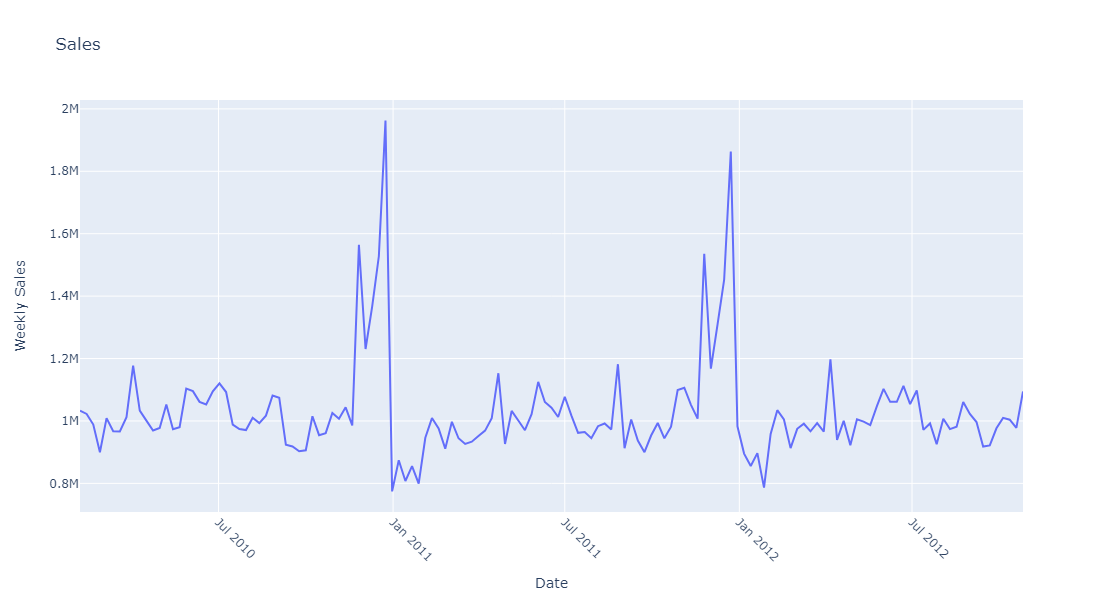

In [164]:
visualize_sales(data=store)

### * We are taking rolling avg of three months to check data is stationary or not

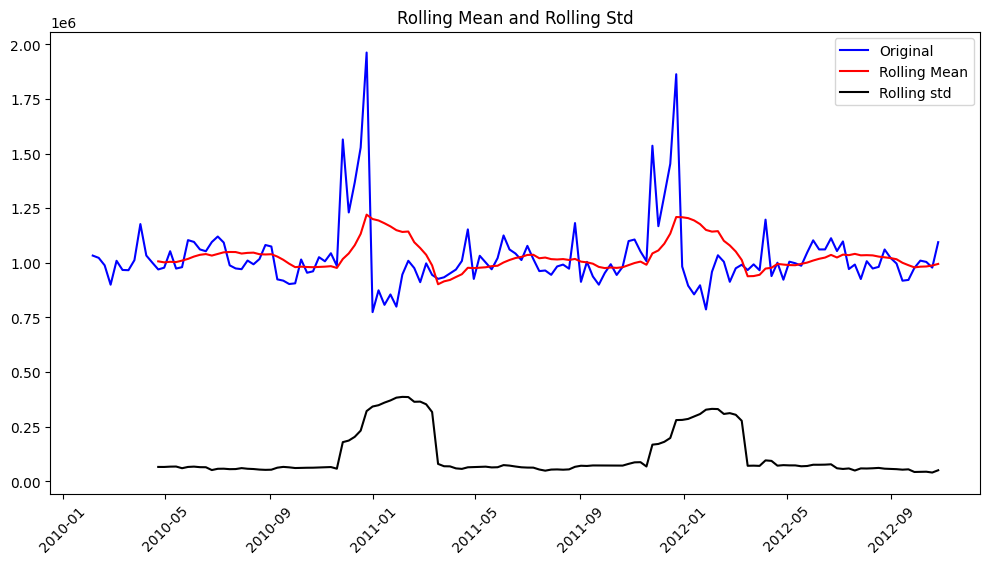

In [165]:
plot_rolling_statistics(data=store)

### -> We can see data is not stationary as mean snd std is fluctuating so we will take log of weekly sales.

In [166]:
store = apply_log_transformation(data = store)

In [167]:
store

Weekly_Sales
Date                    
2010-02-05     13.847995
2010-02-12     13.837831
2010-02-19     13.803911
2010-02-26     13.709885
2010-03-05     13.824670
...                  ...
2012-09-28     13.791709
2012-10-05     13.825349
2012-10-12     13.819542
2012-10-19     13.793294
2012-10-26     13.905738

[143 rows x 1 columns]

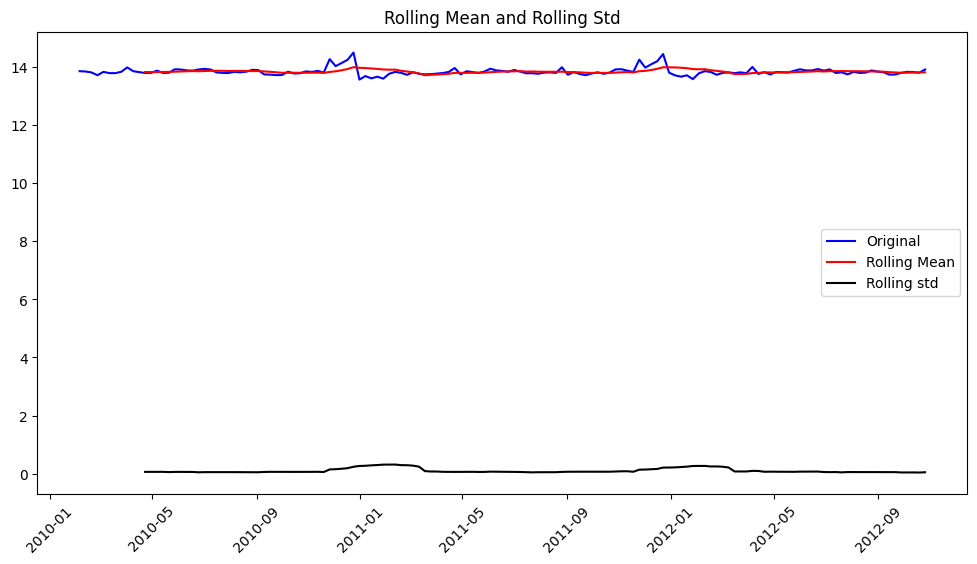

In [168]:
plot_rolling_statistics(data=store)

### * Checking stationarity using statistical method named dickey-fuller test.

In [169]:
adf_test(data=store)

ADF Statistic,-6.5508729923189035
p-value=8.857913763298357e-09
critical_value = {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
series is stationary


### * here we are checking seasonality, trend, randomness of our processed data.

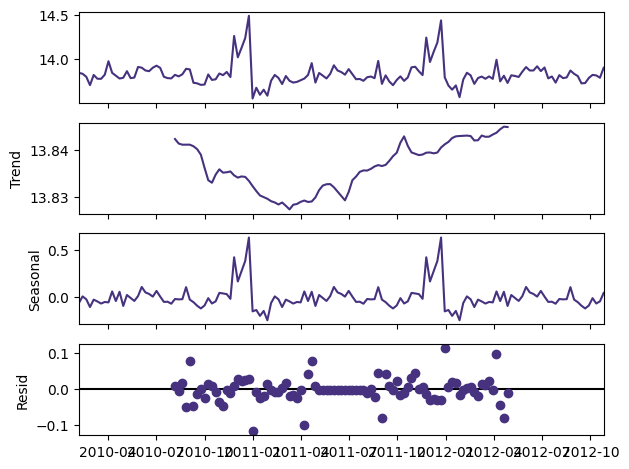

In [170]:
decompose_seasonality(data = store)

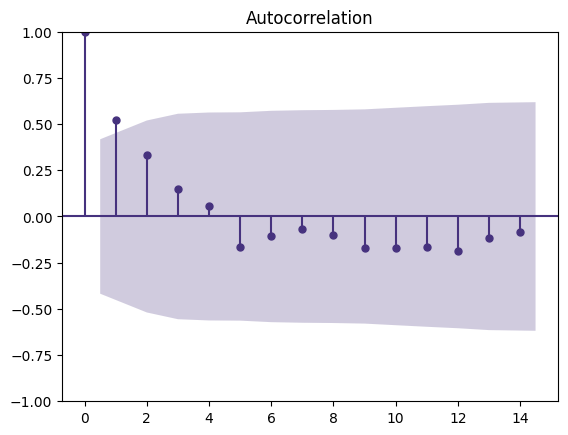

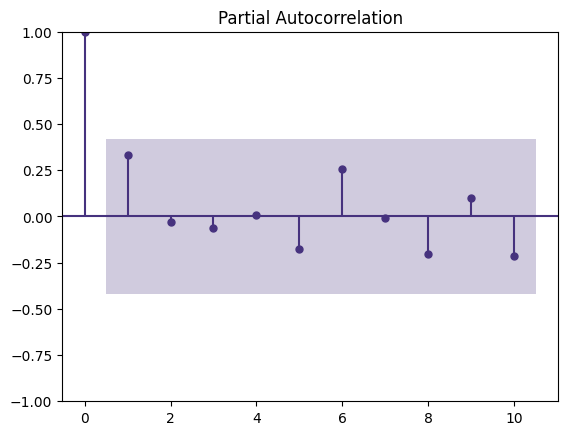

In [172]:
plot_acf_pacf(data=store)

### * Spliting Data into train and test and building model.

In [173]:
train,test = train_test_split(store,test_size=0.1,shuffle=False)

In [174]:
model = build_sarimax_model(train,1,0,4,52)

In [175]:
predict = model.forecast(test.shape[0])

In [176]:
predict

2012-07-20    13.793178
2012-07-27    13.777101
2012-08-03    13.810826
2012-08-10    13.811523
2012-08-17    13.807498
2012-08-24    13.942768
2012-08-31    13.786369
2012-09-07    13.796758
2012-09-14    13.753498
2012-09-21    13.723748
2012-09-28    13.759357
2012-10-05    13.819300
2012-10-12    13.769867
2012-10-19    13.795118
2012-10-26    13.883111
Freq: W-FRI, Name: predicted_mean, dtype: float64

### * Now we will convert our log values to actual real values.

In [178]:
actual_store = np.exp(store)
actual_store = np.round(actual_store,2)

actual_predict = np.exp(predict)
actual_predict = np.round(actual_predict,2)

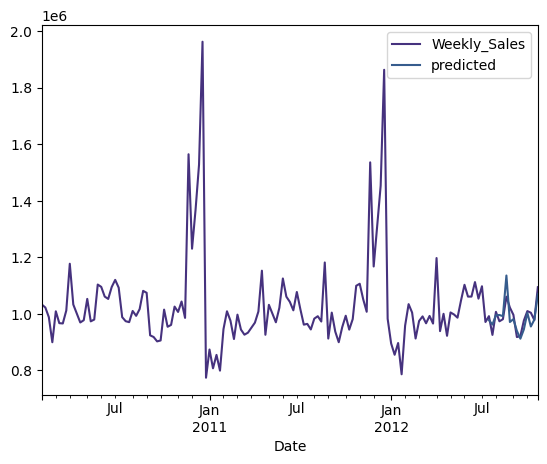

In [190]:
visualize(actual_store,actual_predict)

### * Let's calculate erros between test data and predicted data.

In [191]:
actual_test = np.exp(test)

In [192]:
evaluate_model(actual_predict,actual_test)

r2_score: 0.5314805310201435
Mean Absolute Error (MAE): 25316.384666666636
Mean Squared Error (MSE): 1016683931.4920582
Root Mean Squared Error (RMSE): 31885.48151576291


### * Predicting sales for next 12 weeks.

In [193]:
forecast = model.forecast(steps=test.shape[0]+12)

In [194]:
actual_forecast = np.exp(forecast)
actual_forecast = np.round(actual_forecast,2)

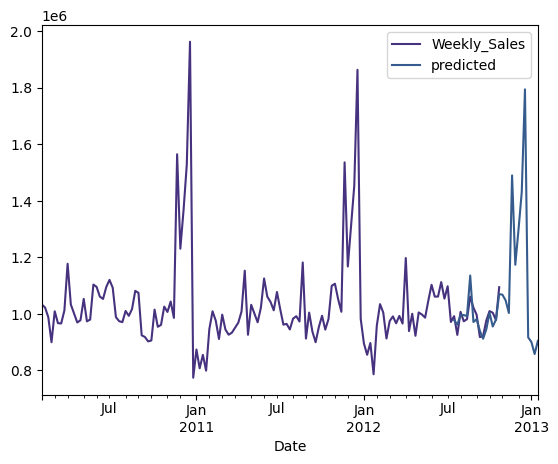

In [195]:
visualize(actual_store,actual_forecast)

### Sales for next 12 weeks is like this.

In [196]:
actual_forecast

2012-07-20     977914.86
2012-07-27     962318.83
2012-08-03     995326.76
2012-08-10     996020.00
2012-08-17     992019.23
2012-08-24    1135709.49
2012-08-31     971278.49
2012-09-07     981421.79
2012-09-14     939871.46
2012-09-21     912321.48
2012-09-28     945394.30
2012-10-05    1003796.59
2012-10-12     955382.42
2012-10-19     979813.65
2012-10-26    1069937.75
2012-11-02    1067954.47
2012-11-09    1047614.18
2012-11-16    1003184.42
2012-11-23    1489674.51
2012-11-30    1173658.94
2012-12-07    1298411.56
2012-12-14    1430566.37
2012-12-21    1793948.15
2012-12-28     916821.23
2013-01-04     900465.64
2013-01-11     858123.24
2013-01-18     904373.80
Freq: W-FRI, Name: predicted_mean, dtype: float64

### * For Store No. 44.

### * Load Data for perticuler store.

In [186]:
store = load_store_data(data,44)

In [187]:
store

Weekly_Sales
Date                    
2010-02-05     281090.95
2010-02-12     286857.13
2010-02-19     267956.30
2010-02-26     273079.07
2010-03-05     284617.27
...                  ...
2012-09-28     355307.94
2012-10-05     337390.44
2012-10-12     337796.13
2012-10-19     323766.77
2012-10-26     361067.07

[143 rows x 1 columns]

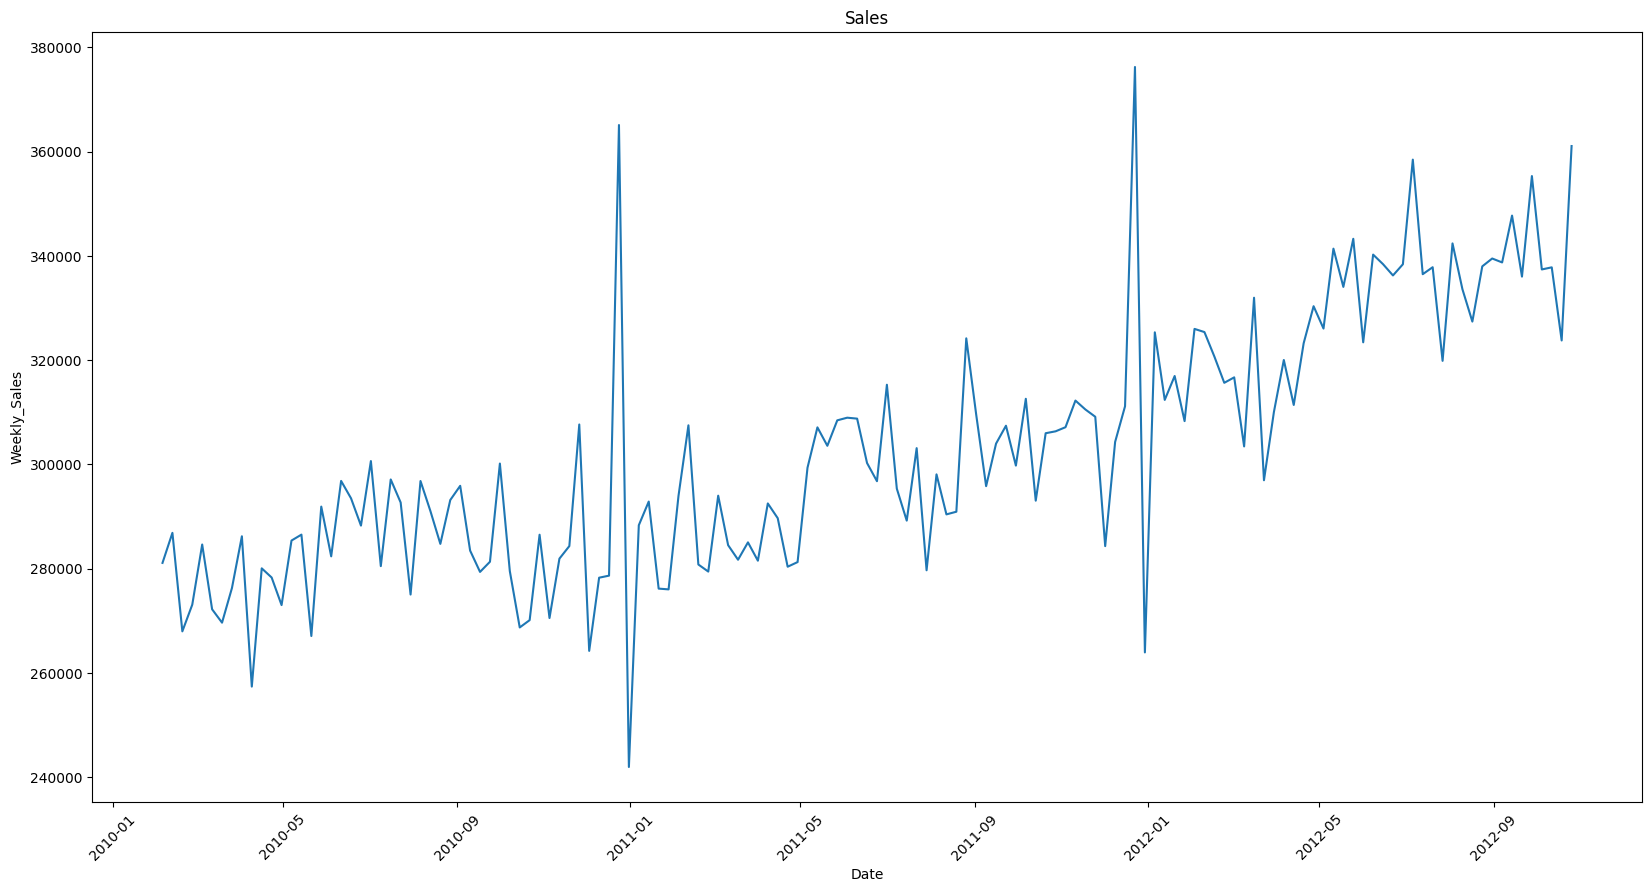

In [188]:
visualize_sales(data=store)

### * We are taking rolling avg of three months to check data is stationary or not.

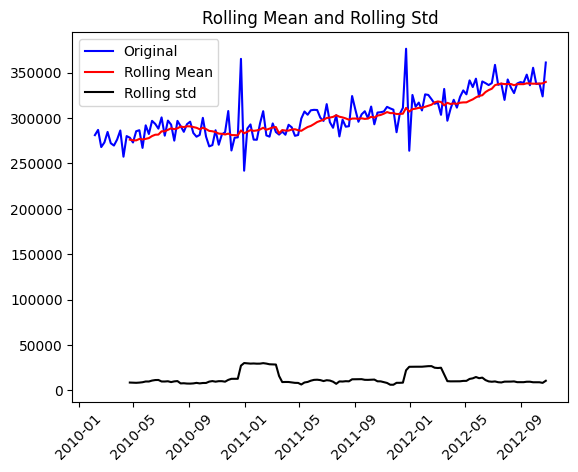

In [189]:
plot_rolling_statistics(data=store)

### -> We can see data is not stationary as mean snd std is fluctuating so we will take log of weekly sales.

In [190]:
log_store = apply_log_transformation(data = store)

In [191]:
log_store

Weekly_Sales
Date                    
2010-02-05     12.546434
2010-02-12     12.566740
2010-02-19     12.498579
2010-02-26     12.517517
2010-03-05     12.558901
...                  ...
2012-09-28     12.780740
2012-10-05     12.728996
2012-10-12     12.730198
2012-10-19     12.687779
2012-10-26     12.796819

[143 rows x 1 columns]

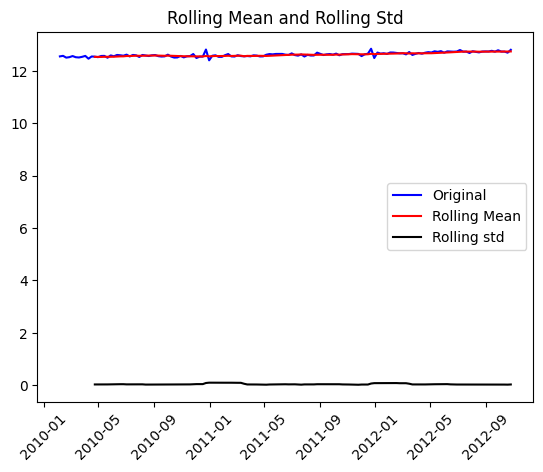

In [192]:
plot_rolling_statistics(data=log_store)

### * Checking stationarity using statistical method named dickey-fuller test and kpss test.

In [193]:
adf_test(data=log_store)

ADF Statistic,-0.9844074052424784
p-value=0.7589087750515391
critical_value = {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}
The series is not stationary


In [194]:
kpss_test(data = log_store)

KPSS Statistic: 1.5381311732352905
p-value: 0.01
Lags Used: 8
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is not stationary


### -> Our series is not stationary so we will apply differentiation.

In [195]:
rolling_mean = log_store['Weekly_Sales'].rolling(window=12).mean()

log_store['Weekly_Sales'] = log_store['Weekly_Sales'] - rolling_mean
log_store.dropna(inplace=True)
rolling_mean.dropna(inplace=True)

In [196]:
log_store

Weekly_Sales
Date                    
2010-04-23      0.008227
2010-04-30     -0.008529
2010-05-07      0.036259
2010-05-14      0.034652
2010-05-21     -0.033793
...                  ...
2012-09-28      0.051054
2012-10-05     -0.000915
2012-10-12      0.000292
2012-10-19     -0.043140
2012-10-26      0.061473

[132 rows x 1 columns]

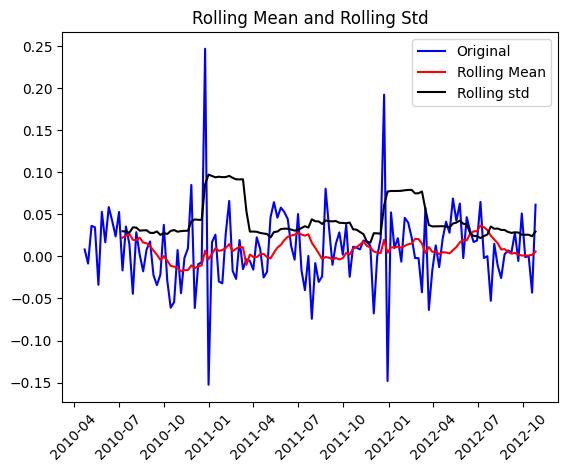

In [197]:
plot_rolling_statistics(data=log_store)

In [198]:
adf_test(data=log_store)

ADF Statistic,-4.421265641221026
p-value=0.00027213975553208467
critical_value = {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}
series is stationary


In [199]:
kpss_test(data=log_store)

KPSS Statistic: 0.09261372446336029
p-value: 0.1
Lags Used: 2
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is stationary


### * here we are checking seasonality, trend, randomness of our processed data.

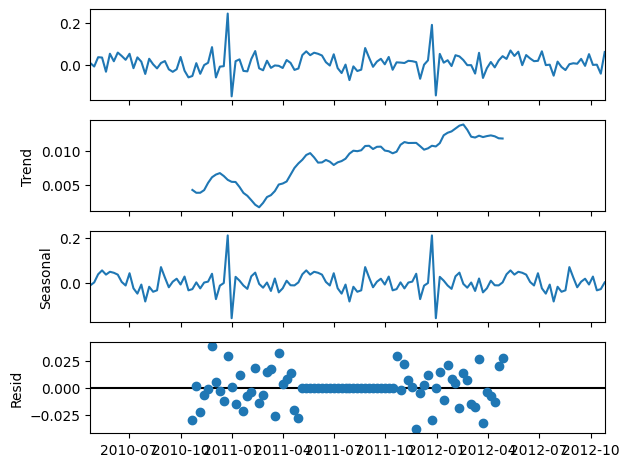

In [200]:
decompose_seasonality(data = log_store)

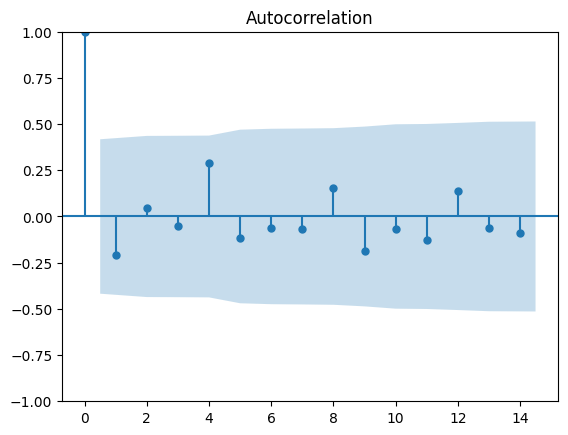

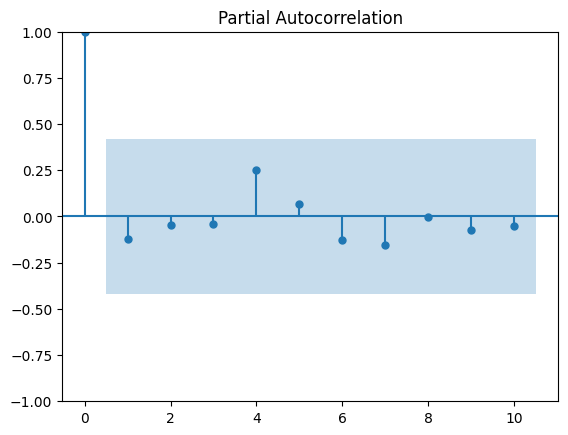

In [201]:
plot_acf_pacf(data=log_store)

### * Spliting Data into train and test for building the model.

In [202]:
train,test = train_test_split(log_store,test_size=0.1,shuffle=False)

In [203]:
model = build_sarimax_model(train,0,1,0,52)

In [204]:
predict = model.forecast(test.shape[0])

In [205]:
predict

2012-07-27   -0.074574
2012-08-03   -0.008363
2012-08-10   -0.030775
2012-08-17   -0.024143
2012-08-24    0.080118
2012-08-31    0.033726
2012-09-07   -0.010409
2012-09-14    0.014813
2012-09-21    0.028154
2012-09-28    0.001712
2012-10-05    0.037112
2012-10-12   -0.024642
2012-10-19    0.011076
2012-10-26    0.009996
Freq: W-FRI, Name: predicted_mean, dtype: float64

### * Now we will convert our log transformed and rolling mean subtrected values to actual real values.

In [206]:
log_predict = predict + rolling_mean[-len(predict):]

In [207]:
log_predict

2012-07-27    12.653876
2012-08-03    12.720332
2012-08-10    12.697808
2012-08-17    12.700493
2012-08-24    12.808428
2012-08-31    12.761852
2012-09-07    12.717800
2012-09-14    12.745821
2012-09-21    12.758577
2012-09-28    12.731398
2012-10-05    12.767023
2012-10-12    12.705264
2012-10-19    12.741995
2012-10-26    12.745342
Freq: W-FRI, dtype: float64

In [208]:
log_test = test['Weekly_Sales'] + rolling_mean[-len(test):]

In [209]:
log_store = log_store['Weekly_Sales'] + rolling_mean

In [210]:
actual_store = np.exp(log_store)
actual_store = np.round(actual_store,2)

actual_predict = np.exp(log_predict)
actual_predict = np.round(actual_predict,2)

In [211]:
actual_predict

2012-07-27    312974.28
2012-08-03    334479.89
2012-08-10    327030.34
2012-08-17    327909.54
2012-08-24    365283.03
2012-08-31    348659.78
2012-09-07    333634.17
2012-09-14    343114.98
2012-09-21    347519.82
2012-09-28    338201.83
2012-10-05    350467.53
2012-10-12    329477.81
2012-10-19    341804.76
2012-10-26    342950.68
Freq: W-FRI, dtype: float64

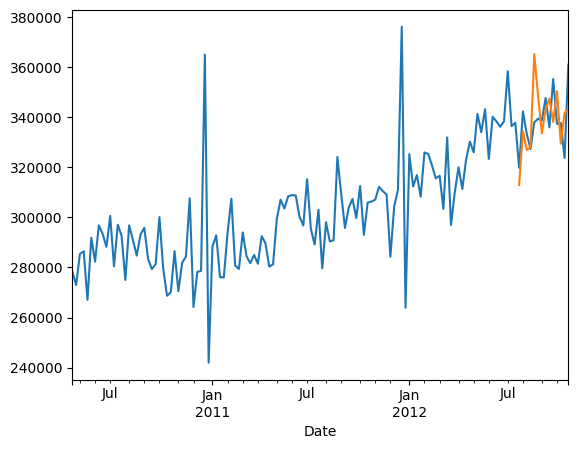

In [212]:
visualize(actual_store,actual_predict)

### * Let's calculate erros between test data and predicted data

In [213]:
actual_test = np.exp(log_test)

In [214]:
evaluate_model(actual_predict,actual_test)

r2_score: -0.45559620119755495
Mean Absolute Error (MAE): 11015.022857142907
Mean Squared Error (MSE): 167744928.5371006
Root Mean Squared Error (RMSE): 12951.638063855113


### -> Here, time series data exhibit seasonality and trends, which are not adequately captured by R-squared. A model might perform well in capturing patterns related to seasonality or trends, but R2 may not reflect this accurately.

### * Predicting sales for next 12 weeks

In [215]:
forecast = model.forecast(steps=test.shape[0]+12)

In [216]:
actual_forecast = np.exp(forecast)
actual_forecast = np.round(actual_forecast,2)

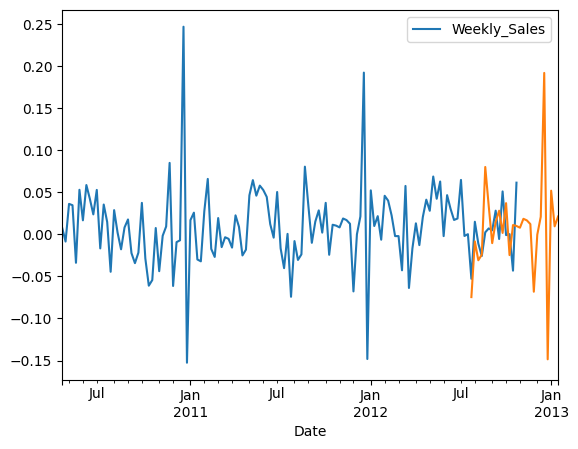

In [217]:
visualize(pd.concat([train,test]),forecast)

### -> Here,ACF and PACF suggest that there is no significant autocorrelation at lag 1 (p=0) and no significant partial autocorrelation at lag 1 (q=0), it may indicate that the time series data can be well-modeled by a simple model such as an Exponential Moving Average (EMA) rather than a more complex ARIMA or SARIMA model.

### * Let's Try EMA for Store No. 44.

In [218]:
store = load_store_data(data,44)

In [219]:
train,test = train_test_split(store,test_size=0.1,shuffle=False)

In [220]:
model = build_esa_model(train,52)

In [221]:
predict = model.forecast(test.shape[0])

In [222]:
predict

2012-07-20    340956.701237
2012-07-27    318391.085430
2012-08-03    349277.643857
2012-08-10    343924.149881
2012-08-17    339268.336289
2012-08-24    351809.042377
2012-08-31    352629.887478
2012-09-07    340651.739774
2012-09-14    338859.868447
2012-09-21    341523.702204
2012-09-28    357352.248135
2012-10-05    342031.461079
2012-10-12    330271.876211
2012-10-19    333838.728168
2012-10-26    348505.119994
Freq: W-FRI, dtype: float64

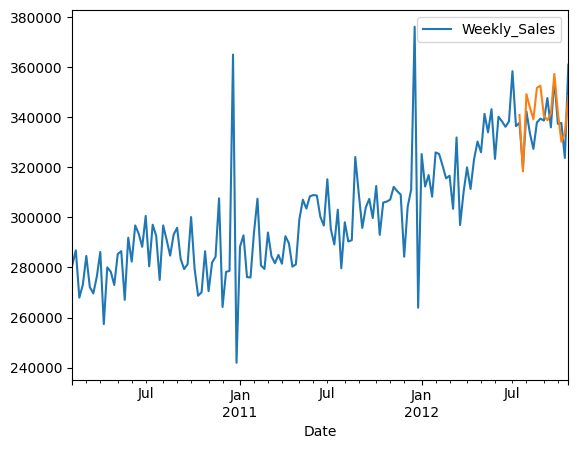

In [223]:
visualize(store,predict)

### * Let's calculate erros between test data and predicted data

In [224]:
evaluate_model(predict,test)

r2_score: 0.3027519840916443
Mean Absolute Error (MAE): 7586.363359741851
Mean Squared Error (MSE): 75013142.76164944
Root Mean Squared Error (RMSE): 8661.012802302595


### * Predicting sales for next 12 weeks

In [225]:
forecast = model.forecast(steps=test.shape[0]+12)

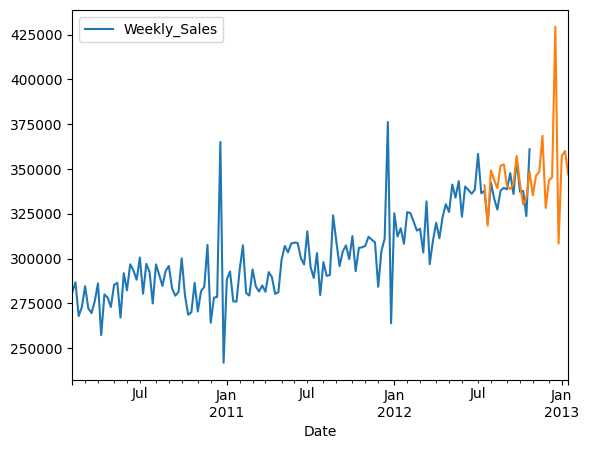

In [226]:
visualize(store,forecast)

### Sales for next 12 weeks is like this.

In [185]:
actual_forecast

2012-07-20    45989706.82
2012-07-27    44980008.28
2012-08-03    49007604.79
2012-08-10    47223818.13
2012-08-17    47909224.74
2012-08-24    47725758.71
2012-08-31    46989835.52
2012-09-07    47214946.50
2012-09-14    44525492.01
2012-09-21    43165268.22
2012-09-28    43225853.51
2012-10-05    47268334.09
2012-10-12    44889031.68
2012-10-19    45657807.67
2012-10-26    45948851.64
2012-11-02    48366992.26
2012-11-09    48460786.92
2012-11-16    46772169.66
2012-11-23    66558503.07
2012-11-30    50292739.04
2012-12-07    56219065.19
2012-12-14    61047876.18
2012-12-21    78135032.38
2012-12-28    44725205.24
2013-01-04    45053026.41
2013-01-11    42401522.59
2013-01-18    42524722.88
Freq: W-FRI, Name: predicted_mean, dtype: float64

## * For Store No. 13.

### * Load data of perticuler store or all stores.

In [62]:
store = load_store_data(data,13)

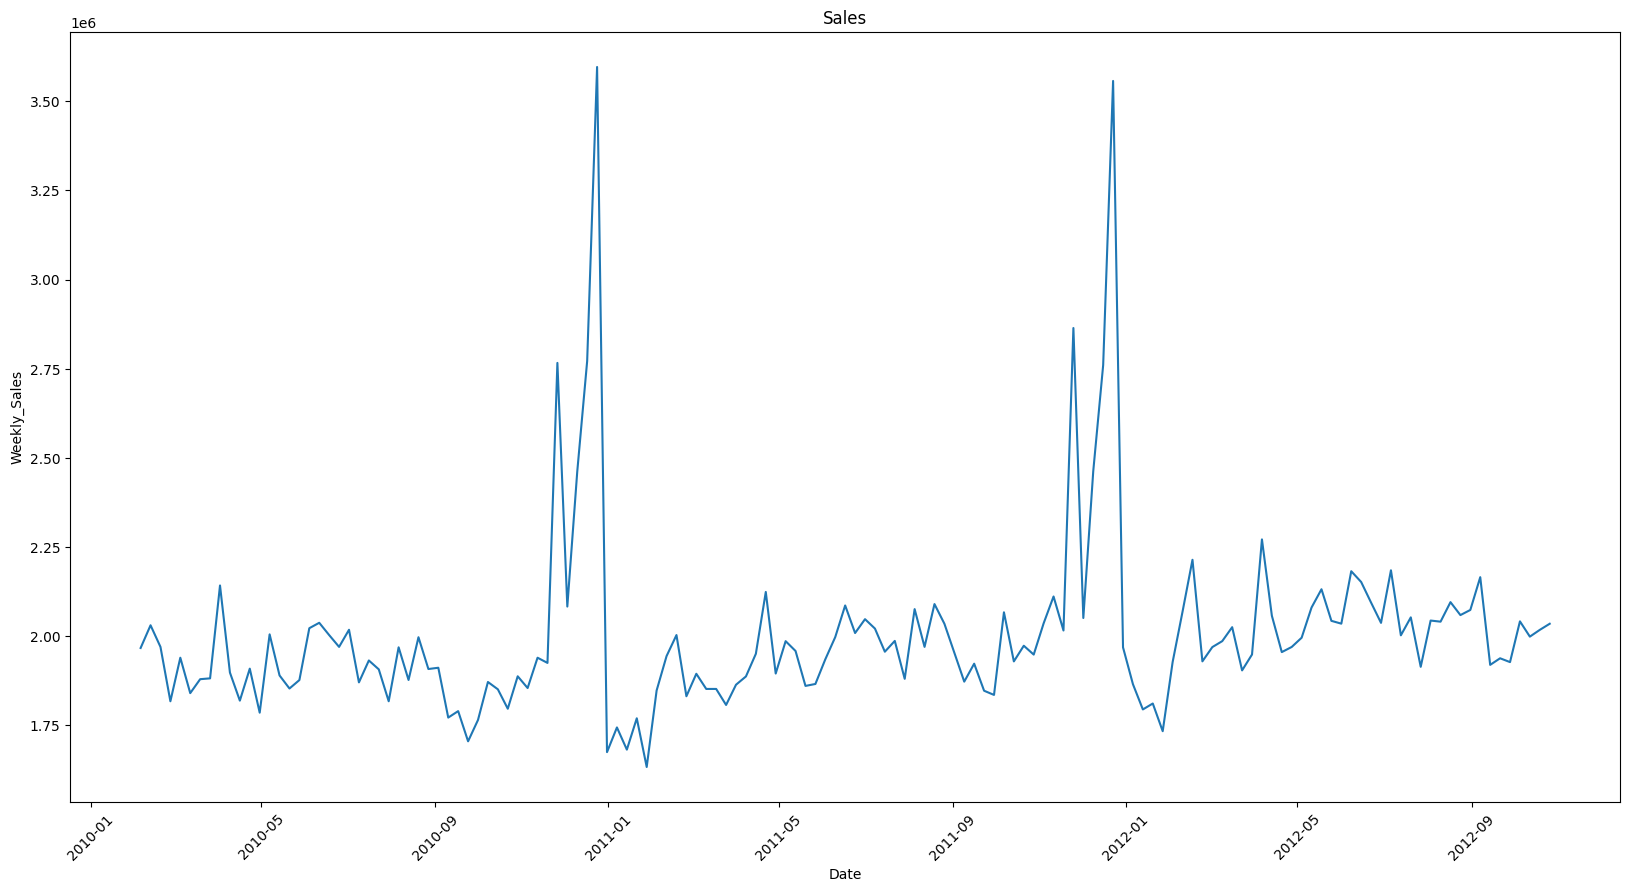

In [63]:
visualize_sales(data=store)

### * We are taking rolling avg of three months to check data is stationary or not.

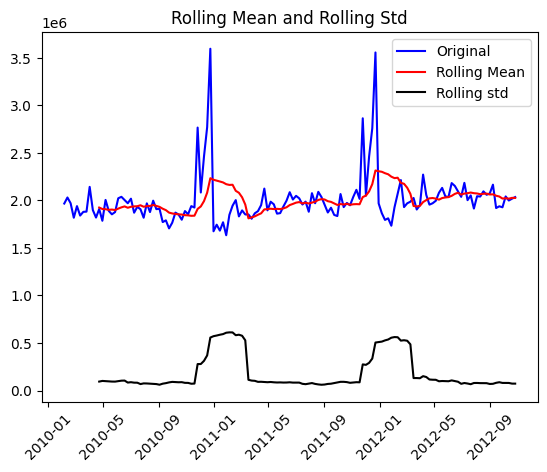

In [64]:
plot_rolling_statistics(data=store)

### -> We can see data is not stationary as mean snd std is fluctuating so we will take log of weekly sales.

In [65]:
store = apply_log_transformation(data = store)

In [66]:
store

Weekly_Sales
Date                    
2010-02-05     14.492132
2010-02-12     14.524006
2010-02-19     14.493684
2010-02-26     14.413165
2010-03-05     14.478188
...                  ...
2012-09-28     14.471820
2012-10-05     14.529400
2012-10-12     14.508197
2012-10-19     14.517623
2012-10-26     14.526100

[143 rows x 1 columns]

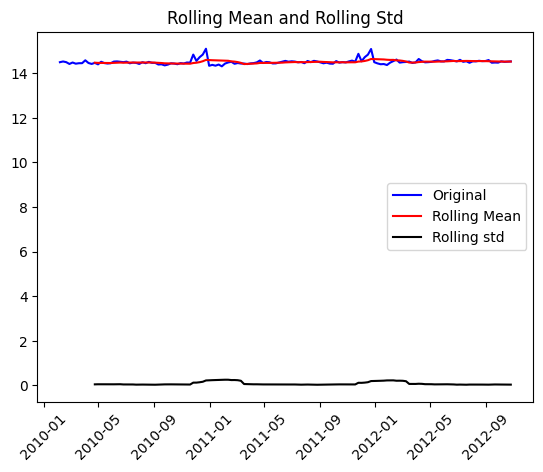

In [67]:
plot_rolling_statistics(data=store)

### * Checking stationarity using statistical method named dickey-fuller test.

In [68]:
adf_test(data=store)

ADF Statistic,-5.709228499529533
p-value=7.365489707745163e-07
critical_value = {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
series is stationary


In [69]:
#store = apply_differanciation(data = store)

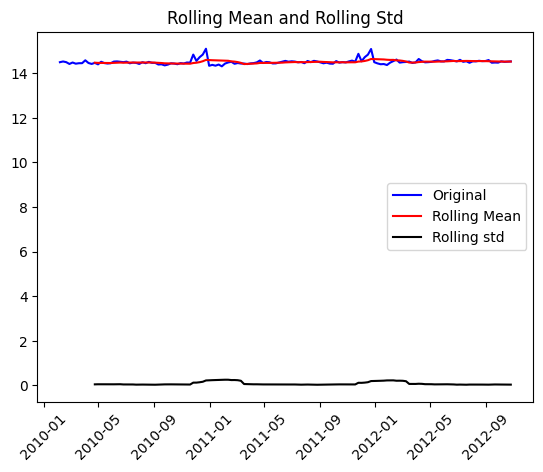

In [70]:
plot_rolling_statistics(data=store)

### * here we are checking seasonality, trend, randomness of our processed data.

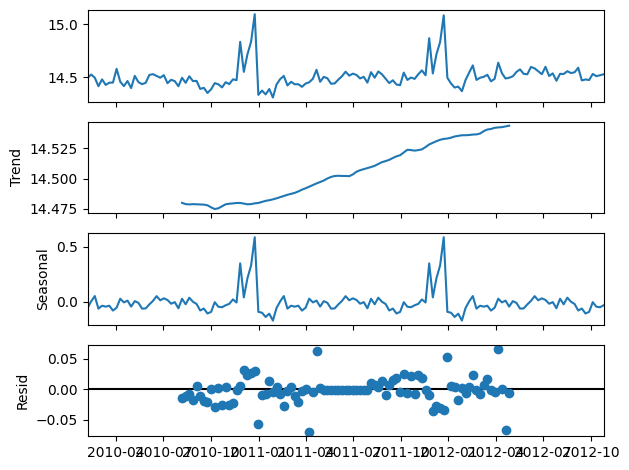

In [71]:
decompose_seasonality(data = store)

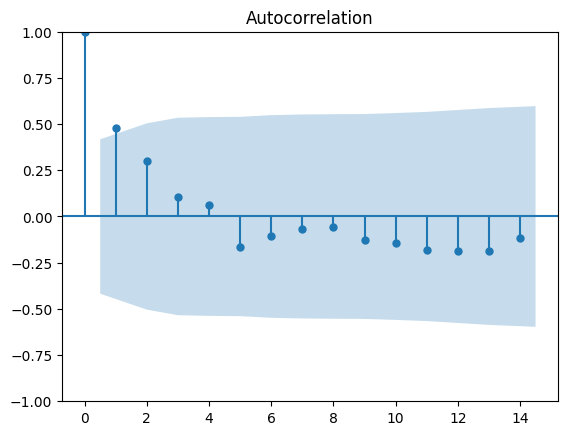

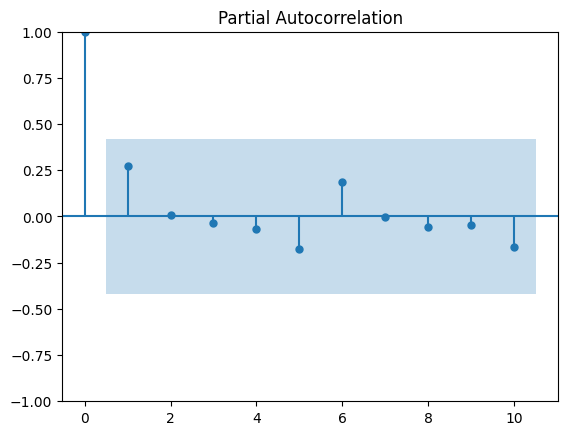

In [72]:
plot_acf_pacf(data=store)

### * Spliting Data into train and test for building the model.

In [73]:
train,test = train_test_split(store,test_size=0.1,shuffle=False)

In [74]:
model = build_sarimax_model(train,1,0,4,52)

In [75]:
predict = model.forecast(test.shape[0])

In [76]:
predict

2012-07-20    14.539737
2012-07-27    14.478594
2012-08-03    14.583604
2012-08-10    14.530967
2012-08-17    14.583725
2012-08-24    14.559177
2012-08-31    14.521962
2012-09-07    14.483453
2012-09-14    14.506816
2012-09-21    14.470148
2012-09-28    14.464022
2012-10-05    14.570384
2012-10-12    14.508057
2012-10-19    14.527737
2012-10-26    14.516025
Freq: W-FRI, Name: predicted_mean, dtype: float64

### * Now we will convert our log values to actual real values.

In [77]:
actual_store = np.exp(store)
actual_store = np.round(actual_store,2)

actual_predict = np.exp(predict)
actual_predict = np.round(actual_predict,2)

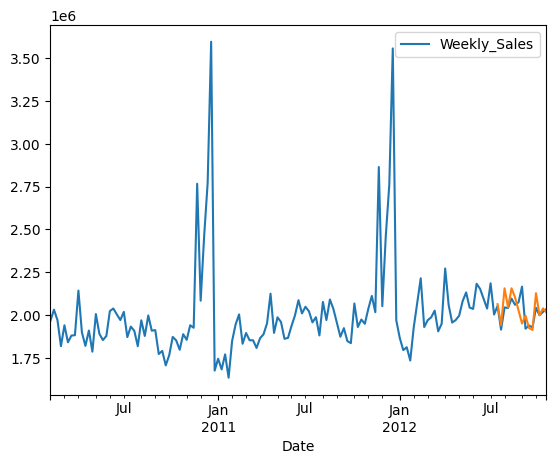

In [78]:
visualize(actual_store,actual_predict)

### * Let's calculate erros between test data and predicted data.

In [79]:
actual_test = np.exp(test)

In [80]:
evaluate_model(actual_predict,actual_test)

r2_score: -0.15299192960429164
Mean Absolute Error (MAE): 50058.89466666603
Mean Squared Error (MSE): 5459464261.435502
Root Mean Squared Error (RMSE): 73888.18756361197


### * Predicting sales for next 12 weeks.

In [81]:
forecast = model.forecast(steps=test.shape[0]+12)

In [82]:
actual_forecast = np.exp(forecast)
actual_forecast = np.round(actual_forecast,2)
#actual_forecast

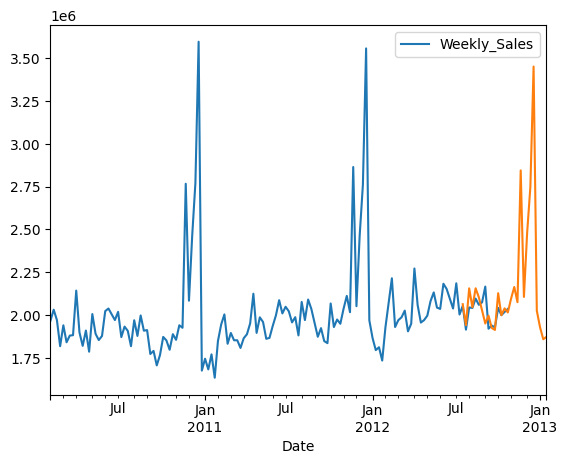

In [84]:
visualize(actual_store,actual_forecast)

### Sales for next 12 weeks is like this.

In [185]:
actual_forecast

2012-07-20    45989706.82
2012-07-27    44980008.28
2012-08-03    49007604.79
2012-08-10    47223818.13
2012-08-17    47909224.74
2012-08-24    47725758.71
2012-08-31    46989835.52
2012-09-07    47214946.50
2012-09-14    44525492.01
2012-09-21    43165268.22
2012-09-28    43225853.51
2012-10-05    47268334.09
2012-10-12    44889031.68
2012-10-19    45657807.67
2012-10-26    45948851.64
2012-11-02    48366992.26
2012-11-09    48460786.92
2012-11-16    46772169.66
2012-11-23    66558503.07
2012-11-30    50292739.04
2012-12-07    56219065.19
2012-12-14    61047876.18
2012-12-21    78135032.38
2012-12-28    44725205.24
2013-01-04    45053026.41
2013-01-11    42401522.59
2013-01-18    42524722.88
Freq: W-FRI, Name: predicted_mean, dtype: float64

## * For Store No. 41.

### * Load data of perticuler store.

In [135]:
store = load_store_data(data,41)

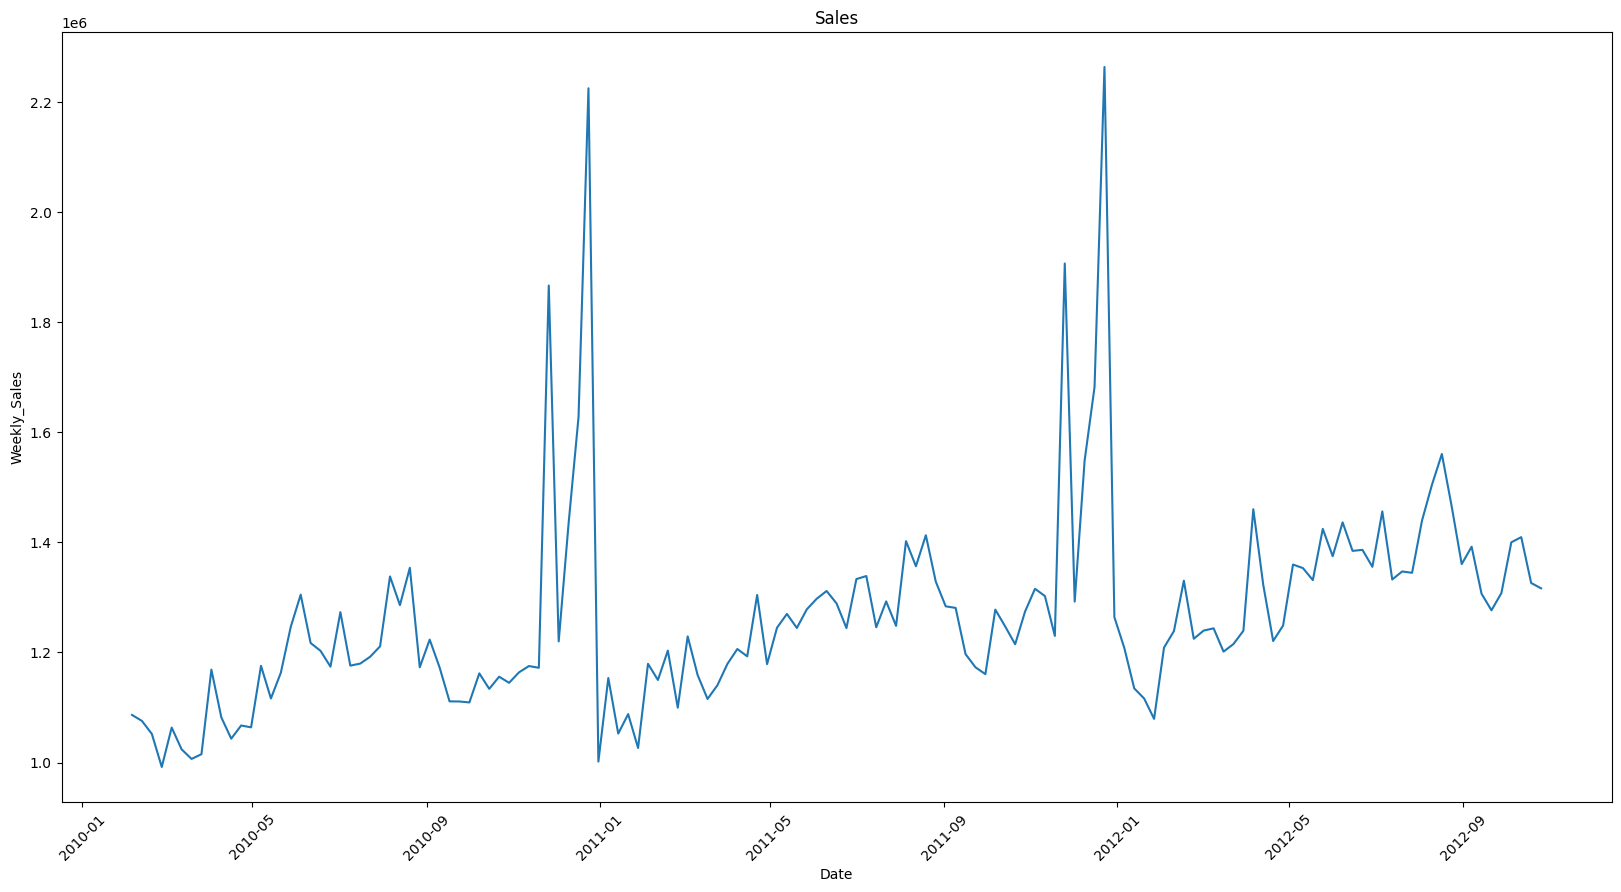

In [136]:
visualize_sales(data=store)

### * We are taking rolling avg of three months to check data is stationary or not.

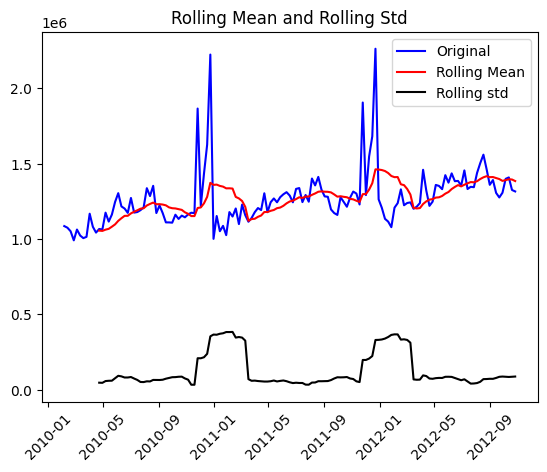

In [137]:
plot_rolling_statistics(data=store)

### -> We can see data is not stationary as mean snd std is fluctuating so we will take log of weekly sales.

In [138]:
store = apply_log_transformation(data = store)

In [160]:
store

Weekly_Sales
Date                    
2010-02-05     13.898503
2010-02-12     13.888442
2010-02-19     13.866237
2010-02-26     13.807420
2010-03-05     13.877130
...                  ...
2012-09-28     14.083955
2012-10-05     14.152098
2012-10-12     14.158777
2012-10-19     14.097826
2012-10-26     14.090520

[143 rows x 1 columns]

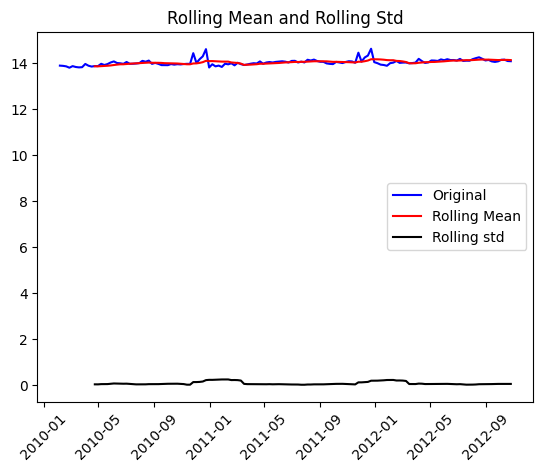

In [141]:
plot_rolling_statistics(data=store)

### * Checking stationarity using statistical method named dickey-fuller test.

In [142]:
adf_test(data=store)

ADF Statistic,-4.4337161981825695
p-value=0.00025860051699209014
critical_value = {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
series is stationary


### * here we are checking seasonality, trend, randomness of our processed data.

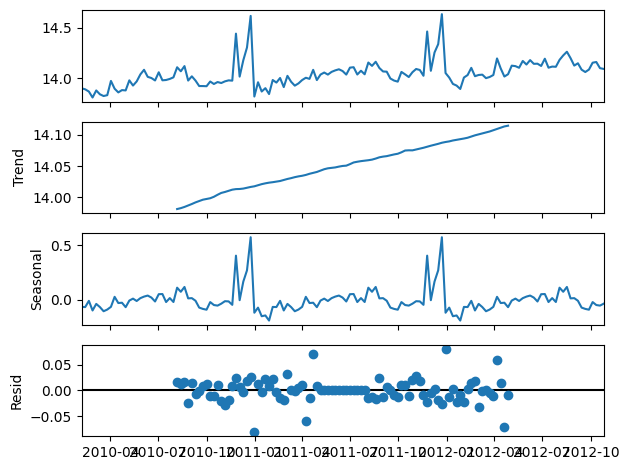

In [144]:
decompose_seasonality(data = store)

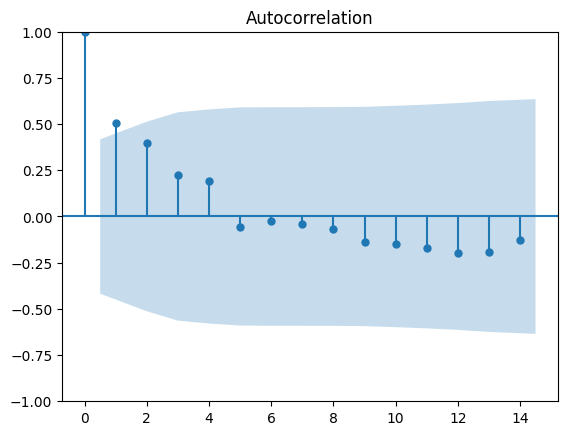

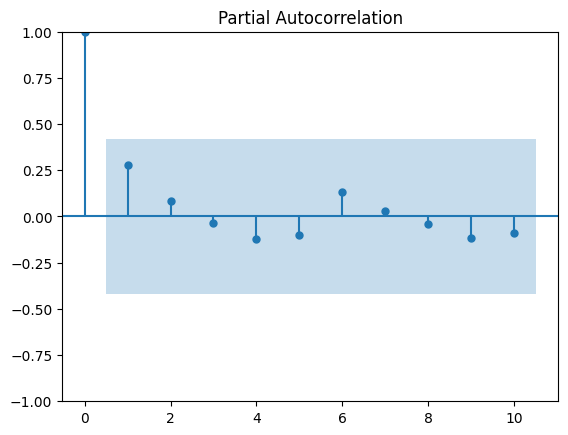

In [145]:
plot_acf_pacf(data=store)

### * Spliting Data into train and test for building the model.

In [146]:
train,test = train_test_split(store,test_size=0.1,shuffle=False)

In [147]:
model = build_sarimax_model(train,2,0,4,52)

In [148]:
predict = model.forecast(test.shape[0])

In [149]:
predict

2012-07-20    14.149056
2012-07-27    14.116417
2012-08-03    14.237399
2012-08-10    14.186860
2012-08-17    14.245628
2012-08-24    14.141815
2012-08-31    14.153226
2012-09-07    14.120560
2012-09-14    14.077632
2012-09-21    14.050199
2012-09-28    14.058743
2012-10-05    14.116062
2012-10-12    14.107956
2012-10-19    14.085009
2012-10-26    14.123618
Freq: W-FRI, Name: predicted_mean, dtype: float64

### * Now we will convert our log values to actual real values.

In [151]:
actual_store = np.exp(store)
actual_store = np.round(actual_store,2)

actual_predict = np.exp(predict)
actual_predict = np.round(actual_predict,2)

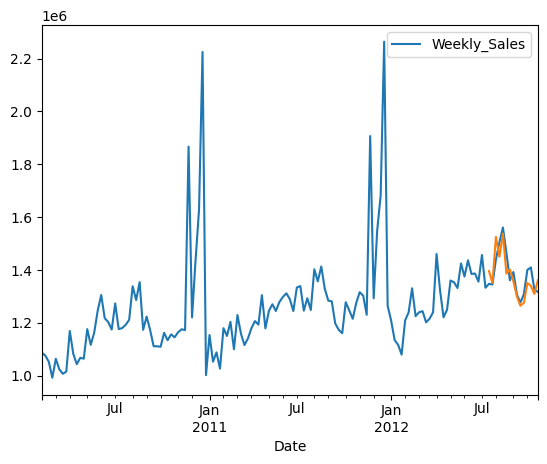

In [152]:
visualize(actual_store,actual_predict)

### * Let's calculate erros between test data and predicted data.

In [153]:
actual_test = np.exp(test)

In [154]:
evaluate_model(actual_predict,actual_test)

r2_score: 0.6347819877195368
Mean Absolute Error (MAE): 40389.85000000011
Mean Squared Error (MSE): 2213384873.924668
Root Mean Squared Error (RMSE): 47046.62446897405


### * Predicting sales for next 12 weeks.

In [155]:
forecast = model.forecast(steps=test.shape[0]+12)

In [156]:
actual_forecast = np.exp(forecast)
actual_forecast = np.round(actual_forecast,2)
#actual_forecast

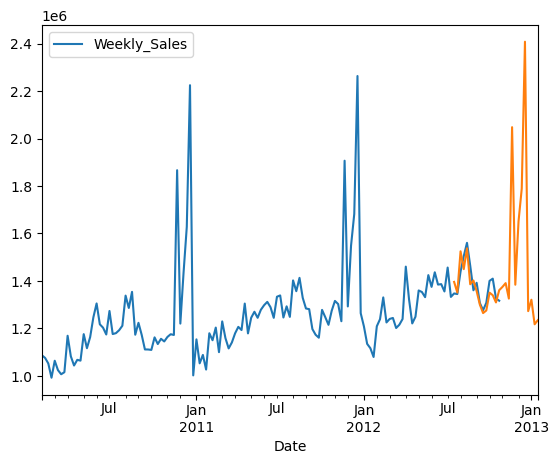

In [158]:
visualize(actual_store,actual_forecast)

### Sales for next 12 weeks is like this.

In [185]:
actual_forecast

2012-07-20    45989706.82
2012-07-27    44980008.28
2012-08-03    49007604.79
2012-08-10    47223818.13
2012-08-17    47909224.74
2012-08-24    47725758.71
2012-08-31    46989835.52
2012-09-07    47214946.50
2012-09-14    44525492.01
2012-09-21    43165268.22
2012-09-28    43225853.51
2012-10-05    47268334.09
2012-10-12    44889031.68
2012-10-19    45657807.67
2012-10-26    45948851.64
2012-11-02    48366992.26
2012-11-09    48460786.92
2012-11-16    46772169.66
2012-11-23    66558503.07
2012-11-30    50292739.04
2012-12-07    56219065.19
2012-12-14    61047876.18
2012-12-21    78135032.38
2012-12-28    44725205.24
2013-01-04    45053026.41
2013-01-11    42401522.59
2013-01-18    42524722.88
Freq: W-FRI, Name: predicted_mean, dtype: float64

## * For All Store.

### * Load data of all stores.

In [161]:
store = load_store_data(data,'All')

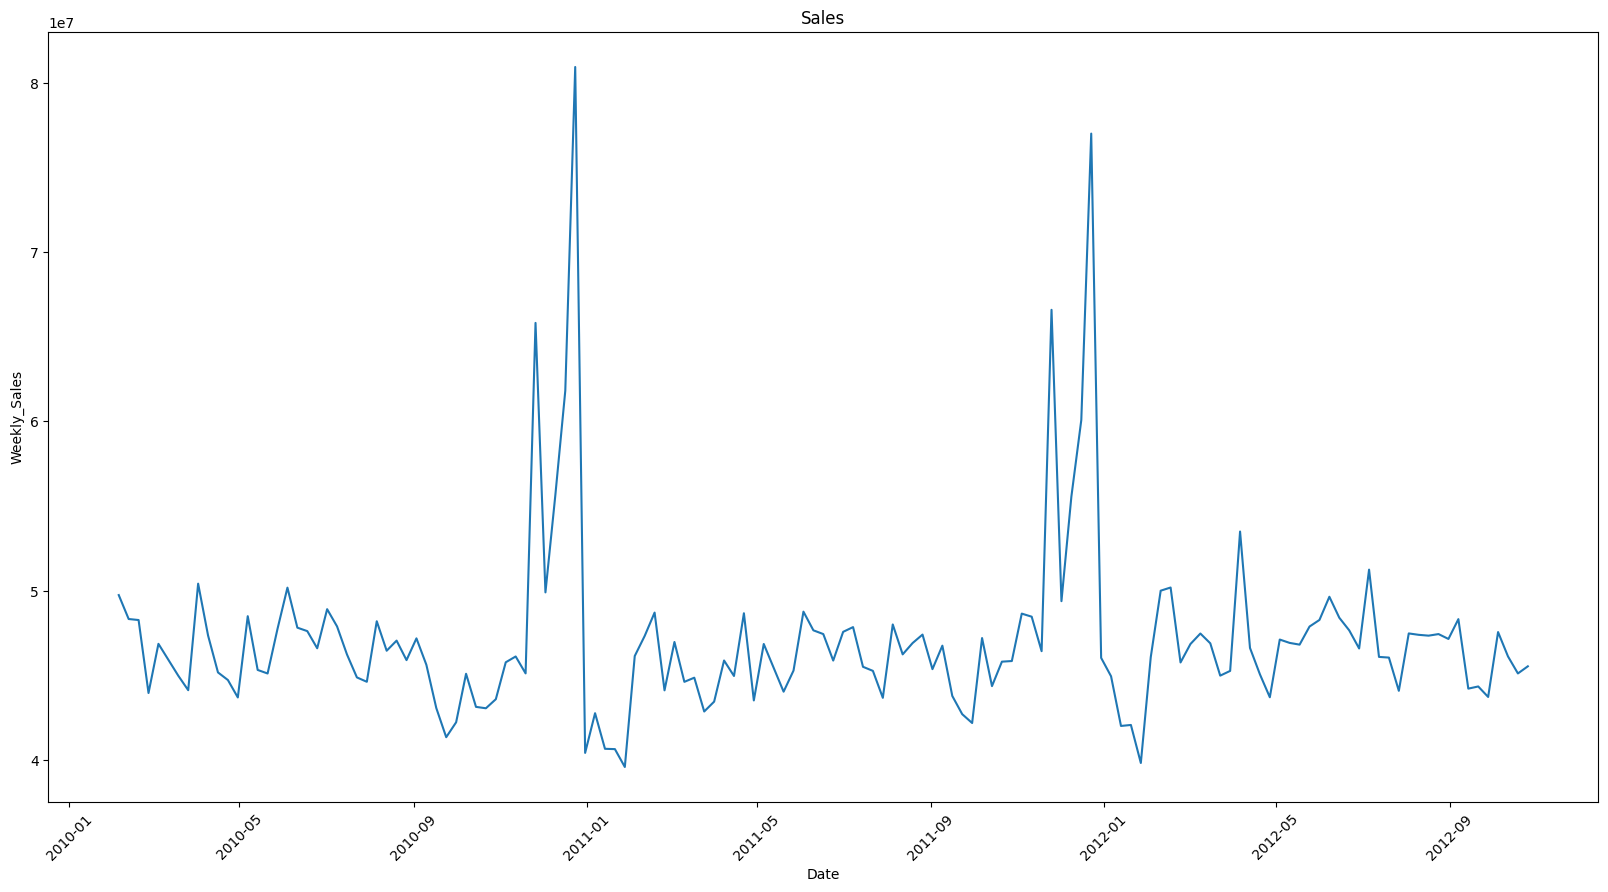

In [162]:
visualize_sales(data=store)

### * We are taking rolling avg of three months to check data is stationary or not.

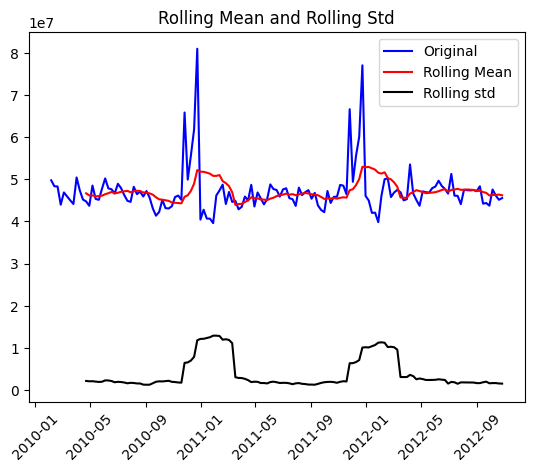

In [163]:
plot_rolling_statistics(data=store)

### -> We can see data is not stationary as mean snd std is fluctuating so we will take log of weekly sales.

In [164]:
store = apply_log_transformation(data = store)

In [166]:
store

Weekly_Sales
Date                    
2010-02-05     17.722536
2010-02-12     17.693701
2010-02-19     17.692466
2010-02-26     17.598986
2010-03-05     17.662920
...                  ...
2012-09-28     17.593657
2012-10-05     17.677642
2012-10-12     17.646942
2012-10-19     17.624890
2012-10-26     17.634192

[143 rows x 1 columns]

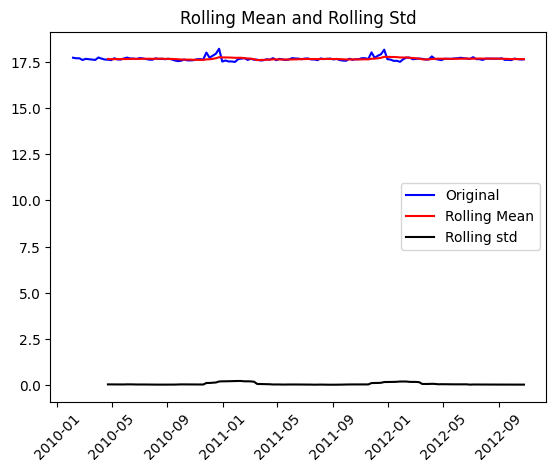

In [167]:
plot_rolling_statistics(data=store)

### * Checking stationarity using statistical method named dickey-fuller test.

In [168]:
adf_test(data=store)

ADF Statistic,-6.332825845560094
p-value=2.8782825472510637e-08
critical_value = {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
series is stationary


### * here we are checking seasonality, trend, randomness of our processed data.

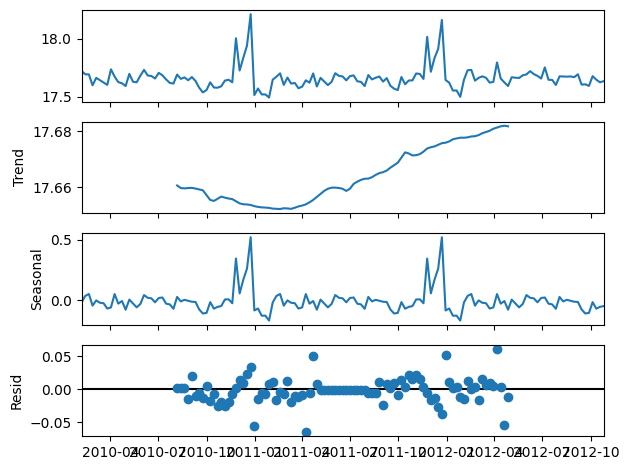

In [171]:
decompose_seasonality(data = store)

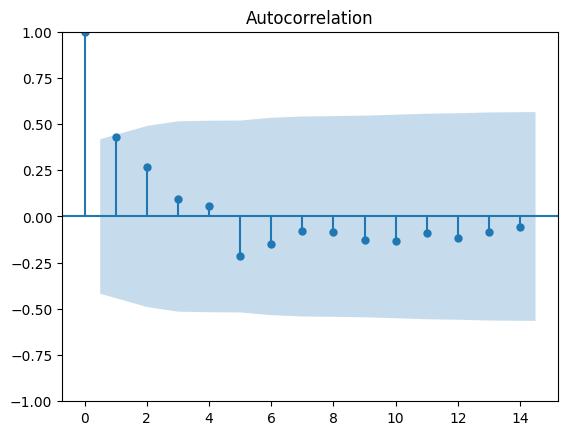

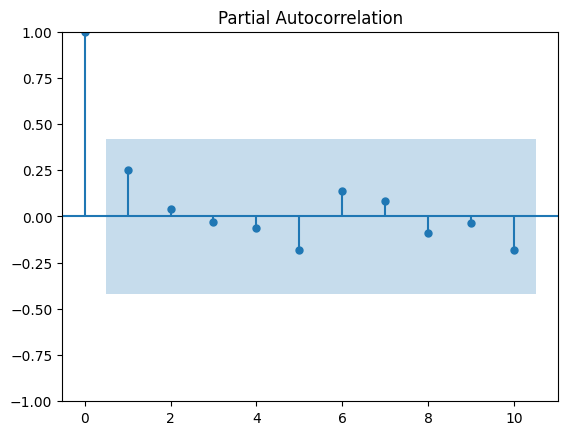

In [172]:
plot_acf_pacf(data=store)

### * Spliting Data into train and test for building the model.

In [173]:
train,test = train_test_split(store,test_size=0.1,shuffle=False)

In [174]:
model = build_sarimax_model(train,2,0,4,52)

In [175]:
predict = model.forecast(test.shape[0])

In [176]:
predict

2012-07-20    17.643928
2012-07-27    17.621729
2012-08-03    17.707486
2012-08-10    17.670409
2012-08-17    17.684819
2012-08-24    17.680982
2012-08-31    17.665442
2012-09-07    17.670221
2012-09-14    17.611572
2012-09-21    17.580547
2012-09-28    17.581949
2012-10-05    17.671351
2012-10-12    17.619704
2012-10-19    17.636685
2012-10-26    17.643039
Freq: W-FRI, Name: predicted_mean, dtype: float64

### * Now we will convert our log values to actual real values.

In [177]:
actual_store = np.exp(store)
actual_store = np.round(actual_store,2)

actual_predict = np.exp(predict)
actual_predict = np.round(actual_predict,2)

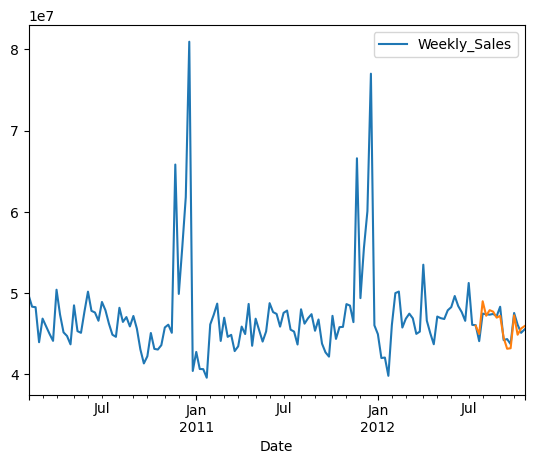

In [178]:
visualize(actual_store,actual_predict)

### * Let's calculate erros between test data and predicted data.

In [179]:
actual_test = np.exp(test)
#actual_test,actual_store['predict'].dropna()

In [180]:
evaluate_model(actual_predict,actual_test)

r2_score: 0.7358709149250378
Mean Absolute Error (MAE): 616523.3986666764
Mean Squared Error (MSE): 575247921409.4674
Root Mean Squared Error (RMSE): 758451.0013240587


### * Predicting sales for next 12 weeks.

In [181]:
forecast = model.forecast(steps=test.shape[0]+12)

In [182]:
actual_forecast = np.exp(forecast)
actual_forecast = np.round(actual_forecast,2)

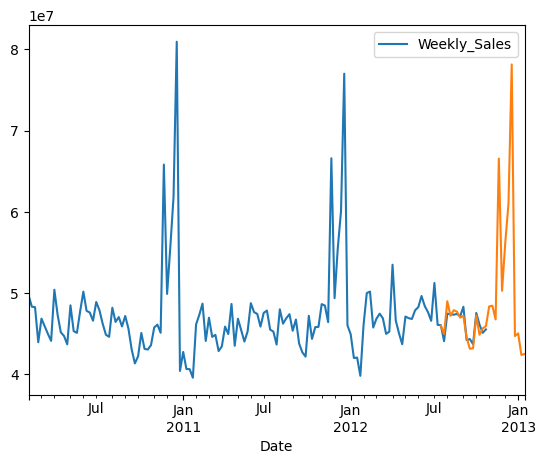

In [184]:
visualize(actual_store,actual_forecast)

### Sales for next 12 weeks is like this.

In [185]:
actual_forecast

2012-07-20    45989706.82
2012-07-27    44980008.28
2012-08-03    49007604.79
2012-08-10    47223818.13
2012-08-17    47909224.74
2012-08-24    47725758.71
2012-08-31    46989835.52
2012-09-07    47214946.50
2012-09-14    44525492.01
2012-09-21    43165268.22
2012-09-28    43225853.51
2012-10-05    47268334.09
2012-10-12    44889031.68
2012-10-19    45657807.67
2012-10-26    45948851.64
2012-11-02    48366992.26
2012-11-09    48460786.92
2012-11-16    46772169.66
2012-11-23    66558503.07
2012-11-30    50292739.04
2012-12-07    56219065.19
2012-12-14    61047876.18
2012-12-21    78135032.38
2012-12-28    44725205.24
2013-01-04    45053026.41
2013-01-11    42401522.59
2013-01-18    42524722.88
Freq: W-FRI, Name: predicted_mean, dtype: float64